### **Import required libraries** 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, TableColumn, DataTable
from bokeh.io import output_notebook
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from IPython.display import display
output_notebook()
import panel as pn
pn.extension()
import holoviews as hv
from ipywidgets import VBox
hv.extension('bokeh')

# Statistics libraries
from scipy import stats
from scipy.stats import norm, shapiro, mannwhitneyu
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import Output  # ✅ Corrected Import
from scipy.stats import anderson
from scripts.analysis import *


Loading BokehJS ...

Loading BokehJS ...

### **Load Data**

In [2]:
# Retrieve data sources as a dictionary using the get_data function
import scripts.parser as sc
data_sources = sc.get_data() # dictionary
df_DSPH = pd.read_csv(data_sources['data_DSPH']) 
df_Glucose = pd.read_csv(data_sources['data_Glucose']) 

## Section 1
### **Inspect data**

In [3]:
df_Glucose.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               5 non-null      object 
 1   Test Type          5 non-null      object 
 2   Glucose(mmol/l)-Z  5 non-null      float64
 3   Glucose(mmol/l)-R  5 non-null      float64
 4   Glucose(mmol/l)-O  5 non-null      float64
 5   Glucose(mmol/l)-J  5 non-null      float64
dtypes: float64(4), object(2)
memory usage: 3.5+ KB


In [4]:
df_DSPH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               57 non-null     object 
 1   Day                                57 non-null     object 
 2   Intake-Dose                        57 non-null     object 
 3   Weight-Z(Kg)                       57 non-null     float64
 4   Weight-R(Kg)                       56 non-null     float64
 5   Weight-O(Kg)                       57 non-null     object 
 6   Weight-J(Kg)                       56 non-null     float64
 7   BMI-Z(kg/m2)                       57 non-null     float64
 8   BMI-R(kg/m2)                       55 non-null     float64
 9   BMI-O(kg/m2)                       57 non-null     float64
 10  BMI-J(kg/m2)                       56 non-null     float64
 11  RMI-Z(kcal)                        56 non-null     object 
 

In [5]:
df_Glucose.head()

,Date,Test Type,Glucose(mmol/l)-Z,Glucose(mmol/l)-R,Glucose(mmol/l)-O,Glucose(mmol/l)-J
0,11/28/2024,BaseLine-Test,4.55,4.85,4.40,3.80
1,12/9/2024,The First_Test (HalfDose),6.15,4.30,5.00,5.30
2,12/19/2024,The Second_Test fullDose),5.40,4.20,4.60,4.60
3,1/9/2025,The Second_Test (HalfDose),5.50,5.55,5.05,5.60
4,1/30/2025,The Second_Test (FullDose),5.15,5.10,6.00,4.95


In [6]:
df_DSPH.head()

,Date,Day,Intake-Dose,Weight-Z(Kg),Weight-R(Kg),Weight-O(Kg),Weight-J(Kg),BMI-Z(kg/m2),BMI-R(kg/m2),BMI-O(kg/m2),...,Heart-rate-O,Heart-rate-J,Blood-Pressure(systolic)(mmHg)-Z\n,Blood-Pressure(systolic)(mmHg)-R\n,Blood-Pressure(systolic)(mmHg)-O\n,Blood-Pressure(systolic)(mmHg)-J\n,Blood-Pressure(diastolic)(mmHg)-Z,Blood-Pressure(diastolic)(mmHg)-R,Blood-Pressure(diastolic)(mmHg)-O,Blood-Pressure(diastolic)(mmHg)-J
0,11/28/2024,Thursday,half-Dose(10days),61.7,89.3,80.2,79.4,22.4,26.7,23.9,...,63,64,88.0,118.0,116,129,66.0,79.0,71,84
1,11/29/2024,Friday,half-Dose(10days),61.6,88.4,80.2,NaN,22.4,26.4,24.1,...,71,71,89.0,106.0,114,134,65.0,71.0,75,80
2,11/30/2024,Saturday,half-Dose(10days),61.7,90.7,80.5,79.1,22.4,27.1,23.6,...,72,65,90.0,114.0,115,130,69.0,76.0,72,89
3,12/1/2024,Sunday,half-Dose(10days),61.7,90.0,80.5,78.1,22.4,26.9,23.9,...,62,65,91.0,NaN,114,133,67.0,77.0,73,87
4,12/2/2024,Monday,half-Dose(10days),61.8,89.2,79.5,78.6,22.5,26.6,24.1,...,71,66,90.0,113.0,113,131,65.0,77.0,77,80


#### **Step1 The number of observations and features**

In [7]:
len(df_DSPH)

57

In [8]:
df = df_DSPH.copy()

### **Function for finding missing values in each column and whole DataFrame**

In [9]:
dic_miss_value, num_miss_df = miss_values(df_DSPH)  # Missing values in the DataFrame
print(f'Missing values in each column: {dic_miss_value}')
print(f'Missing values in the whole DataFrame: {num_miss_df:.2%}')

Missing values in each column: {'Date': np.float64(0.0), 'Day': np.float64(0.0), 'Intake-Dose': np.float64(0.0), 'Weight-Z(Kg)': np.float64(0.0), 'Weight-R(Kg)': np.float64(0.017543859649122806), 'Weight-O(Kg)': np.float64(0.0), 'Weight-J(Kg)': np.float64(0.017543859649122806), 'BMI-Z(kg/m2)': np.float64(0.0), 'BMI-R(kg/m2)': np.float64(0.03508771929824561), 'BMI-O(kg/m2)': np.float64(0.0), 'BMI-J(kg/m2)': np.float64(0.017543859649122806), 'RMI-Z(kcal)': np.float64(0.017543859649122806), 'RMI-R(kcal)': np.float64(0.03508771929824561), 'RMI-O(kcal)': np.float64(0.0), 'RMI-J(kcal)': np.float64(0.017543859649122806), 'Fat-Visceral-Z(%)': np.float64(0.0), 'Fat-Visceral-R(%)': np.float64(0.03508771929824561), 'Fat-Visceral-O(%)': np.float64(0.0), 'Fat-Visceral-J(%)': np.float64(0.017543859649122806), 'Body-Fat-Z(%)': np.float64(0.017543859649122806), 'Body-Fat-R(%)': np.float64(0.03508771929824561), 'Body-Fat-O(%)': np.float64(0.0), 'Body-Fat-J(%)': np.float64(0.017543859649122806), 'Muscle

In [10]:

columns_to_check = ['Weight-I(Kg)', 'Weight-II(Kg)', 'Weight-III(Kg)', 'Weight-IV(Kg)']
df_no_outliers = remove_outliers_iqr(df, columns_to_check)
print(len(df_no_outliers))


Skipping column 'Weight-I(Kg)' (not numeric or not found).
Skipping column 'Weight-II(Kg)' (not numeric or not found).
Skipping column 'Weight-III(Kg)' (not numeric or not found).
Skipping column 'Weight-IV(Kg)' (not numeric or not found).
57


In [11]:
dic_miss_value

{'Date': np.float64(0.0),
 'Day': np.float64(0.0),
 'Intake-Dose': np.float64(0.0),
 'Weight-Z(Kg)': np.float64(0.0),
 'Weight-R(Kg)': np.float64(0.017543859649122806),
 'Weight-O(Kg)': np.float64(0.0),
 'Weight-J(Kg)': np.float64(0.017543859649122806),
 'BMI-Z(kg/m2)': np.float64(0.0),
 'BMI-R(kg/m2)': np.float64(0.03508771929824561),
 'BMI-O(kg/m2)': np.float64(0.0),
 'BMI-J(kg/m2)': np.float64(0.017543859649122806),
 'RMI-Z(kcal)': np.float64(0.017543859649122806),
 'RMI-R(kcal)': np.float64(0.03508771929824561),
 'RMI-O(kcal)': np.float64(0.0),
 'RMI-J(kcal)': np.float64(0.017543859649122806),
 'Fat-Visceral-Z(%)': np.float64(0.0),
 'Fat-Visceral-R(%)': np.float64(0.03508771929824561),
 'Fat-Visceral-O(%)': np.float64(0.0),
 'Fat-Visceral-J(%)': np.float64(0.017543859649122806),
 'Body-Fat-Z(%)': np.float64(0.017543859649122806),
 'Body-Fat-R(%)': np.float64(0.03508771929824561),
 'Body-Fat-O(%)': np.float64(0.0),
 'Body-Fat-J(%)': np.float64(0.017543859649122806),
 'Muscle-Z(%)': 

In [12]:
df = pd.read_csv('Data/Data_DSPH.csv', parse_dates=['Date'], dayfirst=True) 

C:\Users\ztahe\AppData\Local\Temp\ipykernel_38720\3423398374.py:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv('Data/Data_DSPH.csv', parse_dates=['Date'], dayfirst=True)


---

## Section 2
### **Clean data**

In [13]:
df = fill_clear(df, dic_miss_value)

Skipping column 'Date' as it is non-numeric.
Skipping column 'Day' as it is non-numeric.
Skipping column 'Intake-Dose' as it is non-numeric.
Skipping column 'Weight-O(Kg)' as it is non-numeric.
Skipping column 'RMI-Z(kcal)' as it is non-numeric.
Skipping column 'Fat-Visceral-Z(%)' as it is non-numeric.


In [14]:
dic_miss_value

{'Date': np.float64(0.0),
 'Day': np.float64(0.0),
 'Intake-Dose': np.float64(0.0),
 'Weight-Z(Kg)': np.float64(0.0),
 'Weight-R(Kg)': np.float64(0.017543859649122806),
 'Weight-O(Kg)': np.float64(0.0),
 'Weight-J(Kg)': np.float64(0.017543859649122806),
 'BMI-Z(kg/m2)': np.float64(0.0),
 'BMI-R(kg/m2)': np.float64(0.03508771929824561),
 'BMI-O(kg/m2)': np.float64(0.0),
 'BMI-J(kg/m2)': np.float64(0.017543859649122806),
 'RMI-Z(kcal)': np.float64(0.017543859649122806),
 'RMI-R(kcal)': np.float64(0.03508771929824561),
 'RMI-O(kcal)': np.float64(0.0),
 'RMI-J(kcal)': np.float64(0.017543859649122806),
 'Fat-Visceral-Z(%)': np.float64(0.0),
 'Fat-Visceral-R(%)': np.float64(0.03508771929824561),
 'Fat-Visceral-O(%)': np.float64(0.0),
 'Fat-Visceral-J(%)': np.float64(0.017543859649122806),
 'Body-Fat-Z(%)': np.float64(0.017543859649122806),
 'Body-Fat-R(%)': np.float64(0.03508771929824561),
 'Body-Fat-O(%)': np.float64(0.0),
 'Body-Fat-J(%)': np.float64(0.017543859649122806),
 'Muscle-Z(%)': 

### **Imputing Missing Data for 'Historic Glucose mmol/L' and 'Scan Glucose mmol/L'.**

In [15]:
df_filled = fill_clear(df_DSPH, dic_miss_value)  # Fill missing values in numeric columns
print(df_filled)

Skipping column 'Date' as it is non-numeric.
Skipping column 'Day' as it is non-numeric.
Skipping column 'Intake-Dose' as it is non-numeric.
Skipping column 'Weight-O(Kg)' as it is non-numeric.
Skipping column 'RMI-Z(kcal)' as it is non-numeric.
Skipping column 'Fat-Visceral-Z(%)' as it is non-numeric.
          Date        Day          Intake-Dose  Weight-Z(Kg)  Weight-R(Kg)  \
0   11/28/2024   Thursday   half-Dose(10days)           61.7       89.3000   
1   11/29/2024     Friday   half-Dose(10days)           61.6       88.4000   
2   11/30/2024   Saturday   half-Dose(10days)           61.7       90.7000   
3    12/1/2024     Sunday   half-Dose(10days)           61.7       90.0000   
4    12/2/2024     Monday    half-Dose(10days)          61.8       89.2000   
5    12/3/2024    Tuesday   half-Dose(10days)           61.9       89.3000   
6    12/4/2024  Wednesday   half-Dose(10days)           61.9       90.7000   
7    12/5/2024   Thursday   half-Dose(10days)           61.9       89.40

In [16]:
print(len(df_filled))
df_filled.columns

57


Index(['Date', 'Day', 'Intake-Dose', 'Weight-Z(Kg)', 'Weight-R(Kg)',
       'Weight-O(Kg)', 'Weight-J(Kg)', 'BMI-Z(kg/m2)', 'BMI-R(kg/m2)',
       'BMI-O(kg/m2)', 'BMI-J(kg/m2)', 'RMI-Z(kcal)', 'RMI-R(kcal)',
       'RMI-O(kcal)', 'RMI-J(kcal)', 'Fat-Visceral-Z(%)', 'Fat-Visceral-R(%)',
       'Fat-Visceral-O(%)', 'Fat-Visceral-J(%)', 'Body-Fat-Z(%)',
       'Body-Fat-R(%)', 'Body-Fat-O(%)', 'Body-Fat-J(%)', 'Muscle-Z(%)',
       'Muscle-R(%)', 'Muscle-O(%)', 'Muscle-J(%)', 'Heart-rate-Z',
       'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J',
       'Blood-Pressure(systolic)(mmHg)-Z\n',
       'Blood-Pressure(systolic)(mmHg)-R\n',
       'Blood-Pressure(systolic)(mmHg)-O\n',
       'Blood-Pressure(systolic)(mmHg)-J\n',
       'Blood-Pressure(diastolic)(mmHg)-Z',
       'Blood-Pressure(diastolic)(mmHg)-R',
       'Blood-Pressure(diastolic)(mmHg)-O',
       'Blood-Pressure(diastolic)(mmHg)-J'],
      dtype='object')

### **Remove Outlier Values**

In [17]:
columns_to_check = ['Weight-I(Kg)', 'Weight-II(Kg)', 'Weight-III(Kg)', 'Weight-IV(Kg)']
df_no_outliers = remove_outliers_iqr(df_DSPH, columns_to_check)
print(len(df_no_outliers))


Skipping column 'Weight-I(Kg)' (not numeric or not found).
Skipping column 'Weight-II(Kg)' (not numeric or not found).
Skipping column 'Weight-III(Kg)' (not numeric or not found).
Skipping column 'Weight-IV(Kg)' (not numeric or not found).
57


In [18]:
df_DSPH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               57 non-null     object 
 1   Day                                57 non-null     object 
 2   Intake-Dose                        57 non-null     object 
 3   Weight-Z(Kg)                       57 non-null     float64
 4   Weight-R(Kg)                       56 non-null     float64
 5   Weight-O(Kg)                       57 non-null     object 
 6   Weight-J(Kg)                       56 non-null     float64
 7   BMI-Z(kg/m2)                       57 non-null     float64
 8   BMI-R(kg/m2)                       55 non-null     float64
 9   BMI-O(kg/m2)                       57 non-null     float64
 10  BMI-J(kg/m2)                       56 non-null     float64
 11  RMI-Z(kcal)                        56 non-null     object 
 

In [19]:
df_DSPH.columns = df_DSPH.columns.str.strip()
df_filled.columns = df_filled.columns.str.strip()

In [20]:
df_filled.columns = df_filled.columns.str.strip()  # Remove Space from our Char

---

### **Section 3 Heart Rate Analysis**


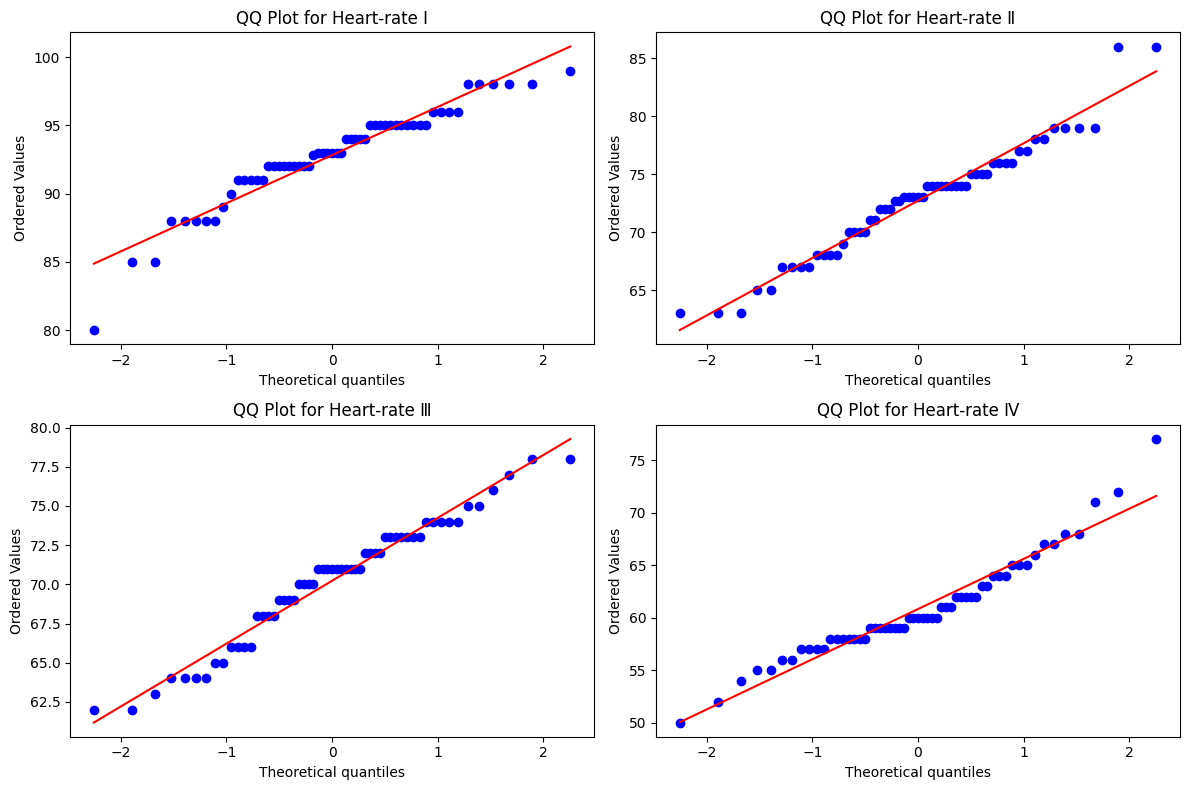

In [21]:

# Define columns and labels
columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
labels = ['Heart-rate Ⅰ', 'Heart-rate Ⅱ', 'Heart-rate Ⅲ', 'Heart-rate Ⅳ']

# Call the function with the dataframe
plot_qq_plots(df_filled, columns, labels)



### **Anderson test for Heart rate to evaulate Normality Data for each participant.**

In [22]:
# Define column names and user labels
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
user_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

# Call the function with your dataframe
anderson_results = anderson_darling_test(df_filled, heart_rate_columns, user_labels)



📌 Anderson-Darling Test for User Ⅰ:
   ➤ Statistic: 1.0990
   ➤ Critical Values: [0.542 0.617 0.741 0.864 1.028]
   ➤ Significance Levels: [15.  10.   5.   2.5  1. ]%

📌 Anderson-Darling Test for User Ⅱ:
   ➤ Statistic: 0.5862
   ➤ Critical Values: [0.542 0.617 0.741 0.864 1.028]
   ➤ Significance Levels: [15.  10.   5.   2.5  1. ]%

📌 Anderson-Darling Test for User Ⅲ:
   ➤ Statistic: 0.7389
   ➤ Critical Values: [0.542 0.617 0.741 0.864 1.028]
   ➤ Significance Levels: [15.  10.   5.   2.5  1. ]%

📌 Anderson-Darling Test for User Ⅳ:
   ➤ Statistic: 1.0328
   ➤ Critical Values: [0.542 0.617 0.741 0.864 1.028]
   ➤ Significance Levels: [15.  10.   5.   2.5  1. ]%


----

### **Interactive Bar Chart for Heart Rate.**

In [23]:
# Define column names and user labels
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
user_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Call the function with your dataframe
fig_heart_rate = plot_average_heart_rate(df_filled, heart_rate_columns, user_labels)
fig_heart_rate.show()


### **Histogram for Heart_rate**

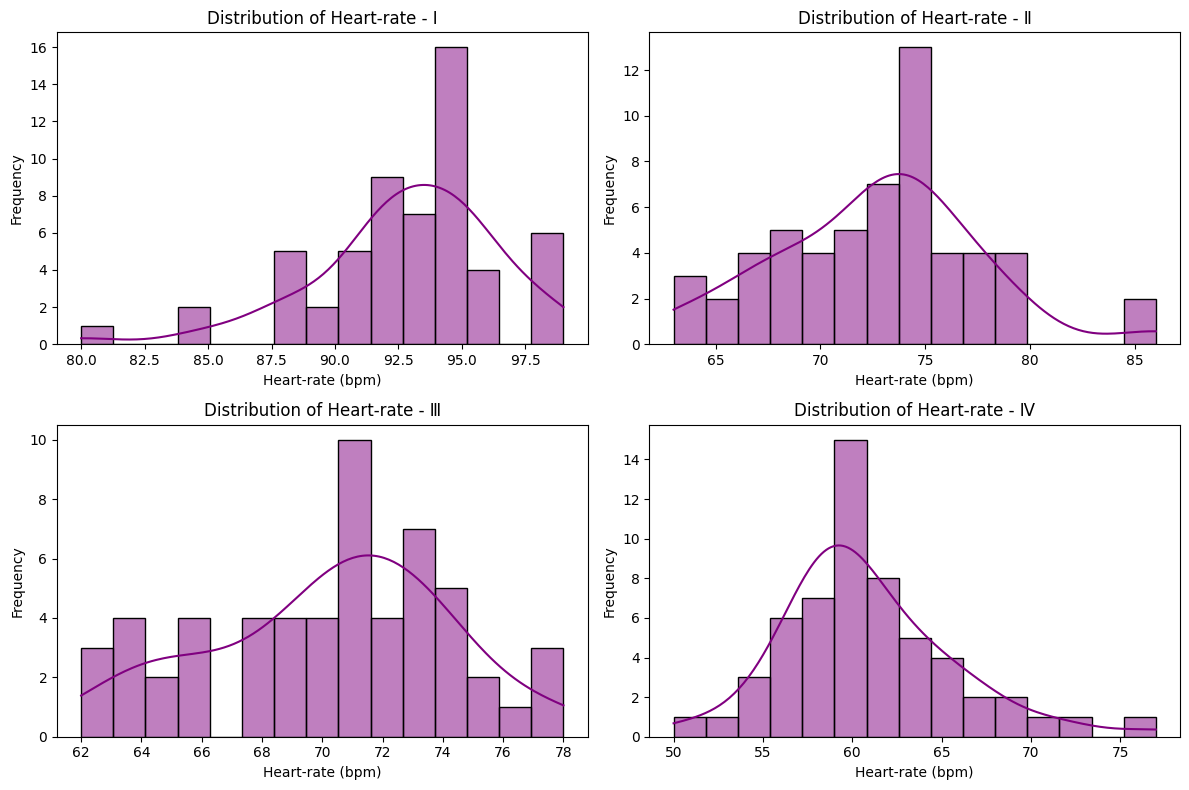

In [24]:
# Define columns and labels
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
user_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Call the function with your dataframe
plot_heart_rate_distribution(df_filled, heart_rate_columns, user_labels)


---

### **Mean Heart Rate, Heart Rate Changes During Different Supplement Doses.**

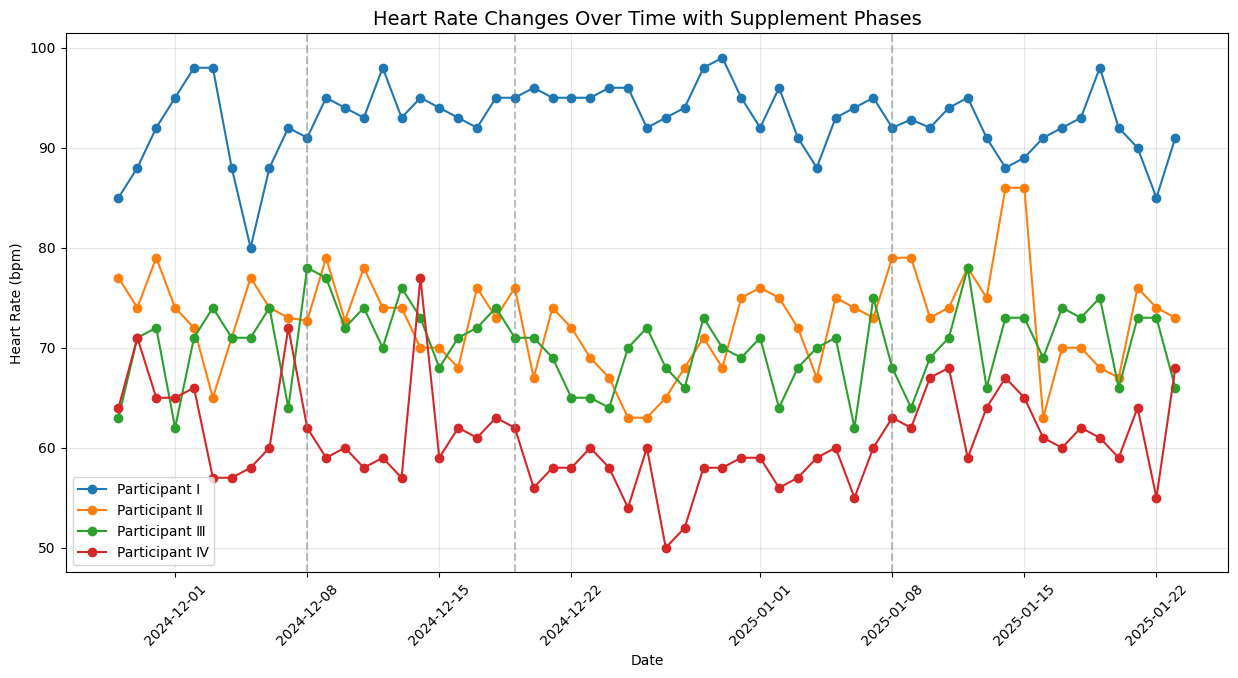

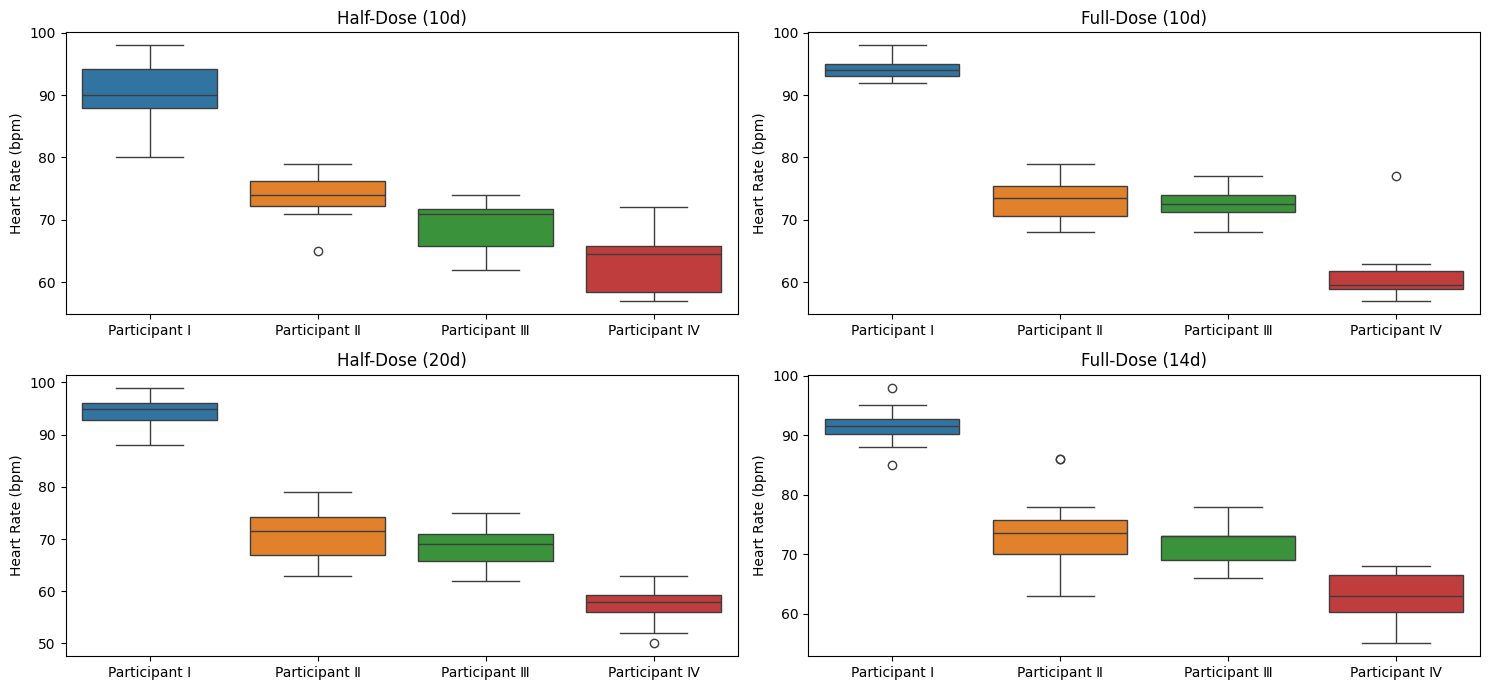

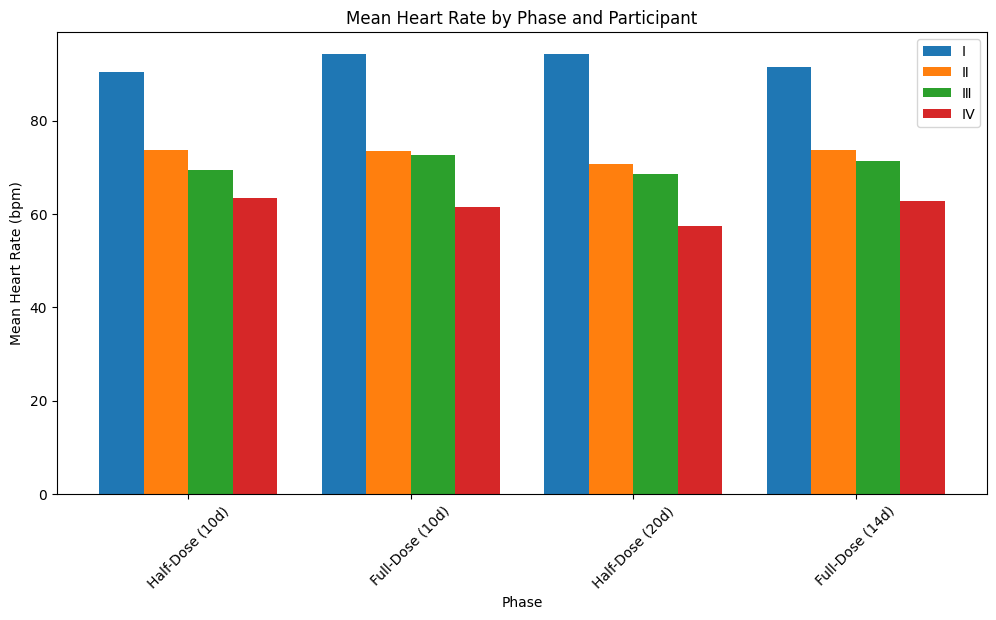

In [25]:
plot_heart_rate_analysis(df_filled)


---

#### **Box plot for Average of Heart Rate for All participants to have a overall view about outliers.**

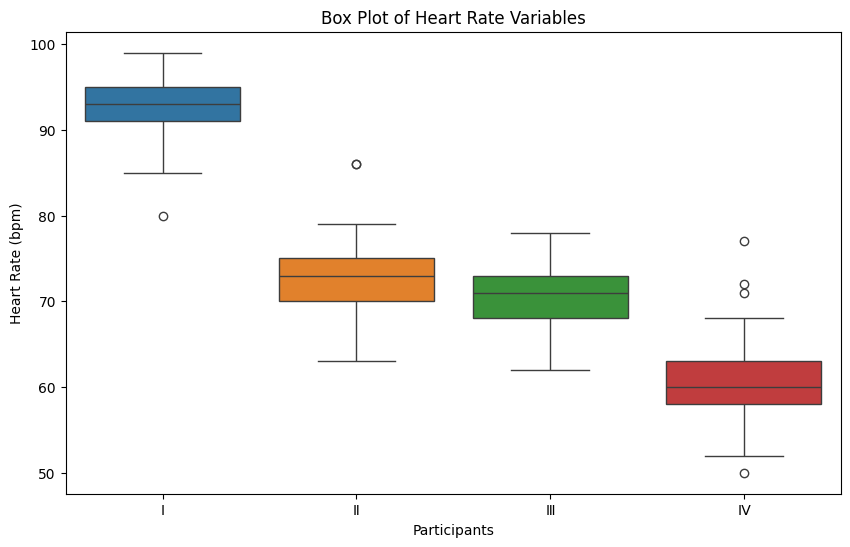

In [26]:
plot_heart_rate_boxplot(df_filled)


---

### **Interactive Section for more evaluation of each user**

### **Interactive heart_rate_over_time for each participant.**

In [27]:
# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define heart rate measurement columns
heart_rate_columns = {
    'I': 'Heart-rate-Z',
    'II': 'Heart-rate-R',
    'III': 'Heart-rate-O',
    'IV': 'Heart-rate-J'
}

# Function to plot heart rate over time
def plot_heart_rate_over_time(selected_user):
    heart_rate_col = heart_rate_columns[selected_user]

    # Filter and clean dataset
    user_data = df_filled[['Date', heart_rate_col]].dropna()
    user_data.rename(columns={heart_rate_col: 'Heart Rate'}, inplace=True)

    # Create a line plot
    plt.figure(figsize=(10, 5))
    plt.plot(user_data['Date'], user_data['Heart Rate'], marker='o', linestyle='-', label=f"Heart Rate - {selected_user}", color='blue')

    # Customize plot appearance
    plt.xlabel('Date')
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'Heart Rate Over Time - User {selected_user}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Show the plot
    plt.show()

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=list(heart_rate_columns.keys()),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(plot_heart_rate_over_time, selected_user=user_dropdown)

Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

interactive(children=(Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=Description…

#### **Interactive Box plot for Average of Heart Rate for All participantsin all Phases.**

In [28]:
# ✅ Function to Run the Interactive Plot
def run_interactive_boxplot(df):
    df_long = prepare_data(df)
    create_interactive_boxplot(df_long)

# ✅ Example Usage
run_interactive_boxplot(df_filled)  # Uncomment this to run the function



Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

interactive(children=(Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III…

###  **Interactive Scatter polt and Linear regression for Heart rate**

In [29]:
plot_heart_rate_regression(df_filled)


### **Interactive Bar chart for Heart rate over phases**

In [30]:
plot_heart_rate_bar_chart(df_filled)

Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

Output()

Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

Output()

<Figure size 1000x500 with 0 Axes>

###  **Interactive Summary Table and Analysis for Heart rate**

In [31]:
interactive_statistics(df_filled)


Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

Output()

---

## **Section 4** 
### **Blood Pressure and Blood Pressure(Systolic, Diastolic) (mmHg)**


### **QQ Plot for Blood pressure(Systolic, Diastolic)**

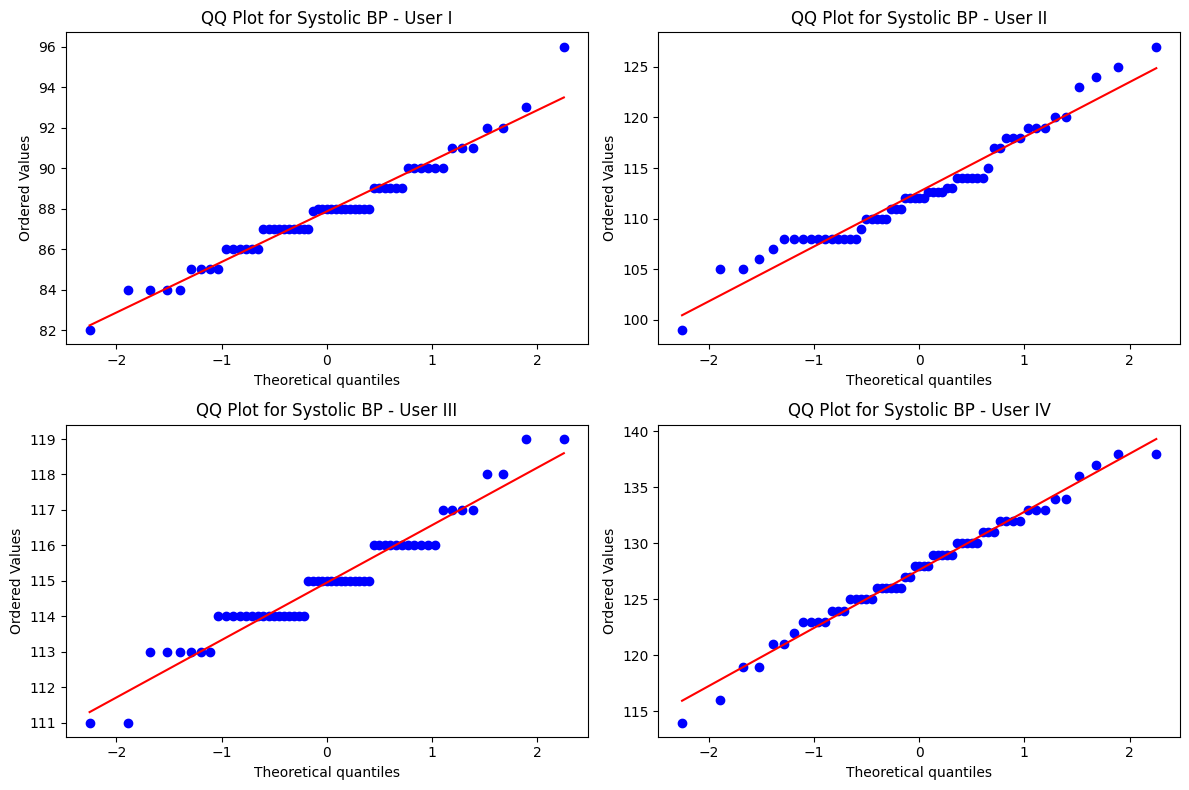

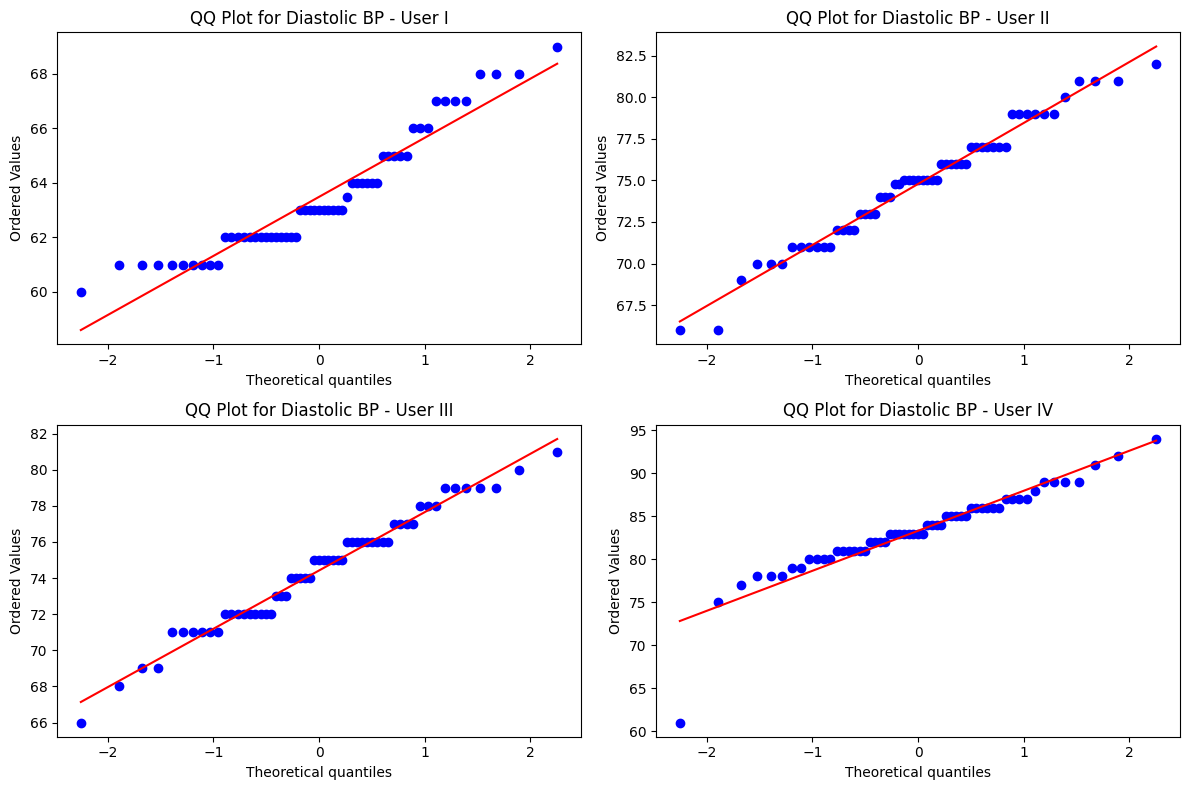

In [32]:

# ✅ Example Usage:
generate_qq_plots(df_filled)  # Uncomment to run


### **Interactive Scatter plot for Blood Prussure(Systolic, Diastolic)**

In [33]:
# Define column names for each metric
systolic_bp_columns = [
    'Blood-Pressure(systolic)(mmHg)-Z', 
    'Blood-Pressure(systolic)(mmHg)-R', 
    'Blood-Pressure(systolic)(mmHg)-O', 
    'Blood-Pressure(systolic)(mmHg)-J'
]

diastolic_bp_columns = [
    'Blood-Pressure(diastolic)(mmHg)-Z', 
    'Blood-Pressure(diastolic)(mmHg)-R', 
    'Blood-Pressure(diastolic)(mmHg)-O', 
    'Blood-Pressure(diastolic)(mmHg)-J'
]

roman_labels = ['User I', 'User II', 'User III', 'User IV']  # Ensuring correct mapping

def create_qq_plot(columns, title, df):
    fig = go.Figure()
    has_data = False  # Track if we add any data to the plot
    all_x_values = []  # Store all x-values for dynamic scaling
    all_y_values = []  # Store all y-values for dynamic scaling

    for col, roman in zip(columns, roman_labels):
        if col not in df.columns:
            print(f"Warning: Column {col} not found in DataFrame, skipping.")
            continue
        
        data = df[col].dropna()
 
        if data.empty:
            print(f"Warning: No valid numeric data for {roman}, skipping.")
            continue  # Skip if no valid data
        
        has_data = True
        
        # Perform Q-Q plot calculation without standardization
        osm, osr = stats.probplot(data, dist="norm")[0]  # Extract only the quantiles
        all_x_values.extend(osm)
        all_y_values.extend(osr)
        # Add scatter plot for each user
        fig.add_trace(go.Scatter(
            x=osm, 
            y=osr, 
            mode='markers', 
            name=f'QQ Plot for {roman}',
            marker=dict(size=8, opacity=0.7, symbol='circle')
        ))

    if not has_data:
        print(f"No valid data for {title}, skipping plot.")
        return  # Do not create an empty plot

    # Adjust X and Y axis dynamically based on real data
    min_x, max_x = min(all_x_values), max(all_x_values)
    min_y, max_y = min(all_y_values), max(all_y_values)

    # Add reference (y=x) line
    fig.add_trace(go.Scatter(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        mode='lines', 
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Theoretical Quantiles",
        yaxis_title="Ordered Values",
        xaxis=dict(range=[min_x, max_x]),
        yaxis=dict(range=[min_y, max_y]),
        template="plotly_white"
    )
    
    #print(f"Displaying {title}...")  # Debugging
    fig.show()


# Ensure only valid columns are processed
df.columns = df.columns.str.strip()
systolic_bp_columns = [col for col in systolic_bp_columns if col in df.columns]
diastolic_bp_columns = [col for col in diastolic_bp_columns if col in df.columns]

# Generate and separately display both plots
create_qq_plot(systolic_bp_columns, "QQ Plot for Systolic Blood Pressure", df)
create_qq_plot(diastolic_bp_columns, "QQ Plot for Diastolic Blood Pressure", df)



In [34]:
print(df_filled[systolic_bp_columns].mean())  
print(df_filled[diastolic_bp_columns].mean())


Blood-Pressure(systolic)(mmHg)-Z     87.857143
Blood-Pressure(systolic)(mmHg)-R    112.660377
Blood-Pressure(systolic)(mmHg)-O    114.947368
Blood-Pressure(systolic)(mmHg)-J    127.631579
dtype: float64
Blood-Pressure(diastolic)(mmHg)-Z    63.482143
Blood-Pressure(diastolic)(mmHg)-R    74.781818
Blood-Pressure(diastolic)(mmHg)-O    74.421053
Blood-Pressure(diastolic)(mmHg)-J    83.315789
dtype: float64


### **Bar Chart for Blood-Pressure(Systolic, Diastolic)** 

In [35]:

# ✅ Example Usage:
plot_blood_pressure(df_filled)  # Uncomment to run


### **Distribution for Blood Pressure(Systolic, Diastolic)**

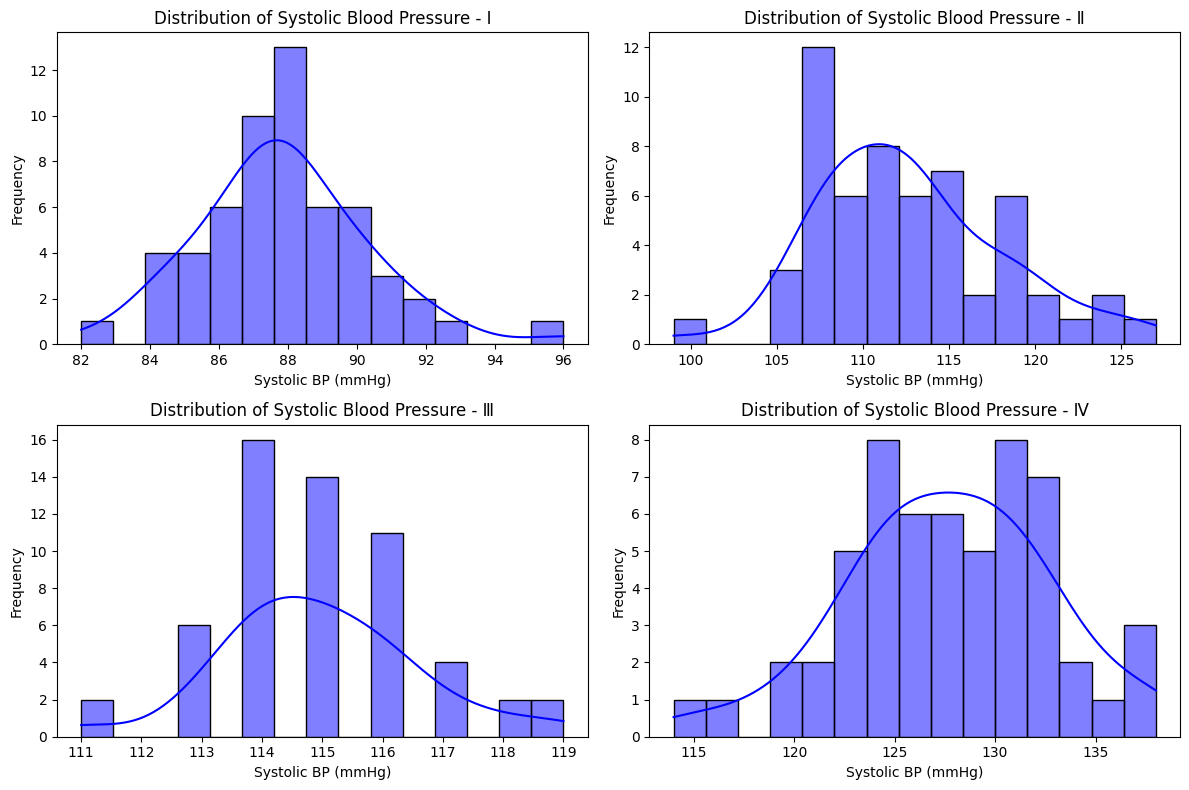

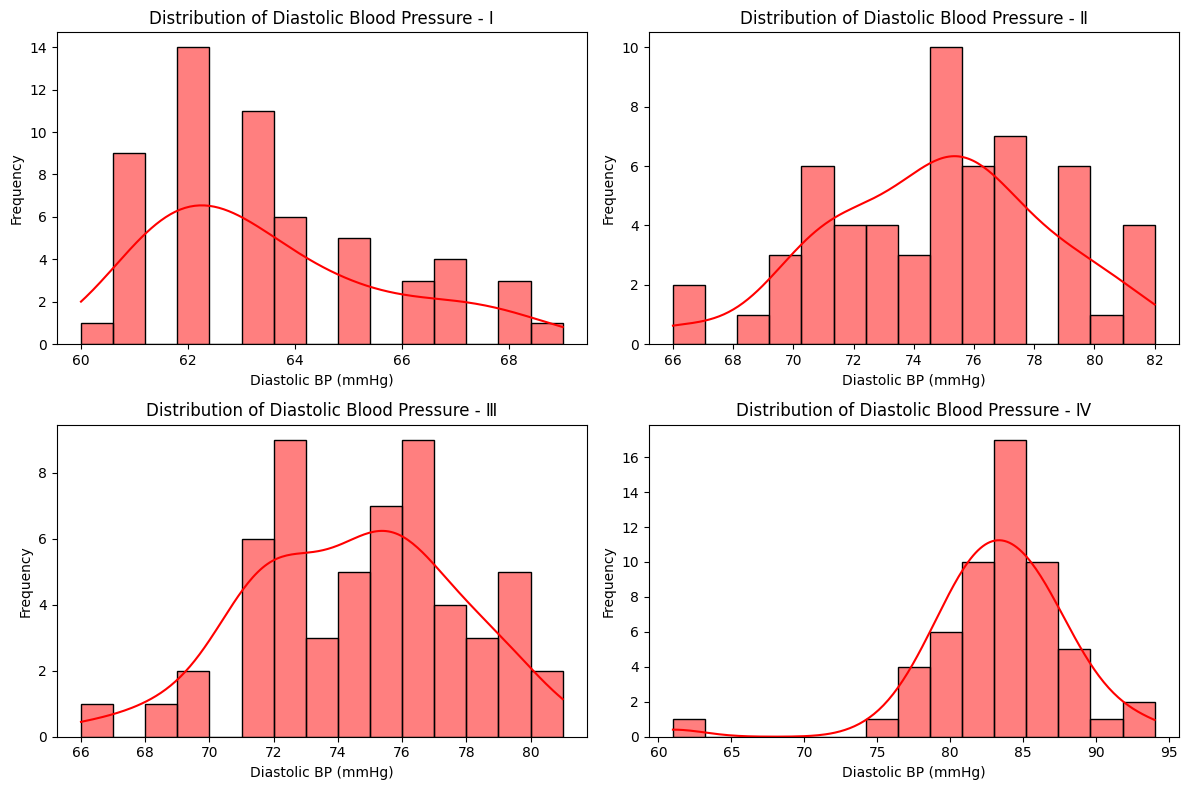

In [36]:
plot_blood_pressure_distribution(df_filled)  

### **Box plot for Blood Prussure(Systolic, Diastolic).**

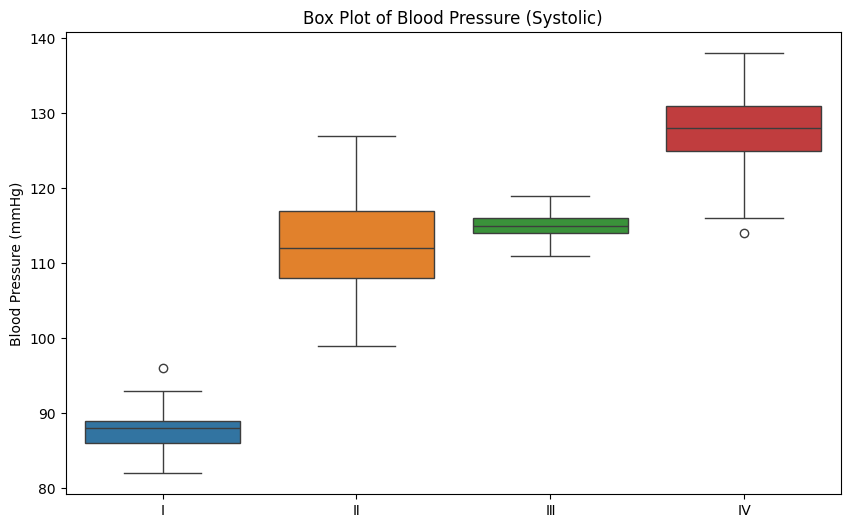

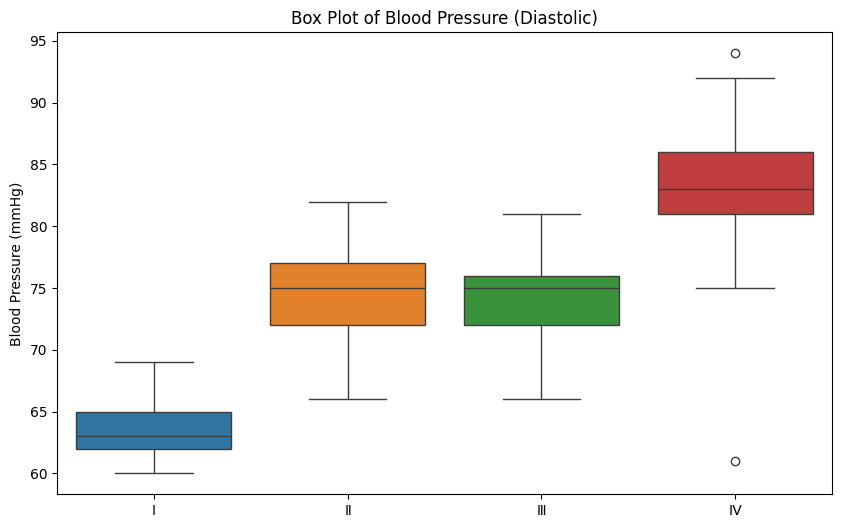

In [37]:
plot_blood_pressure_boxplots(df_DSPH)  # Uncomment to run


### **Blood Pressure(Systolic, Diastolic) Changes During Different Supplement Doses**

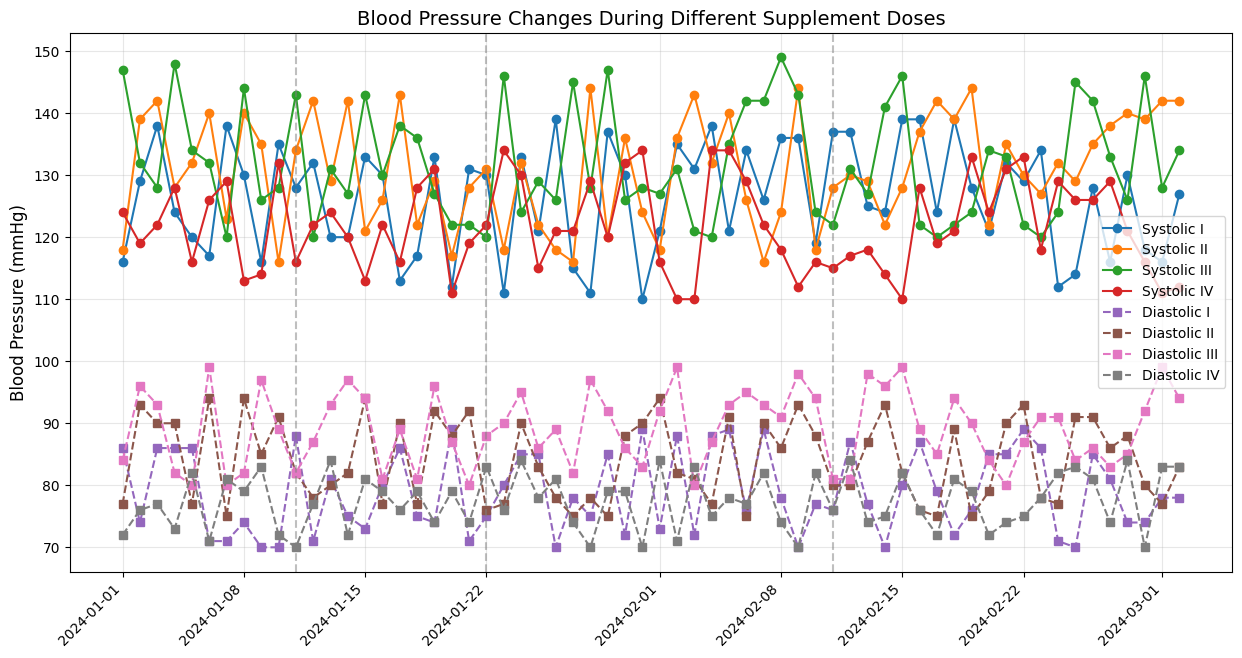

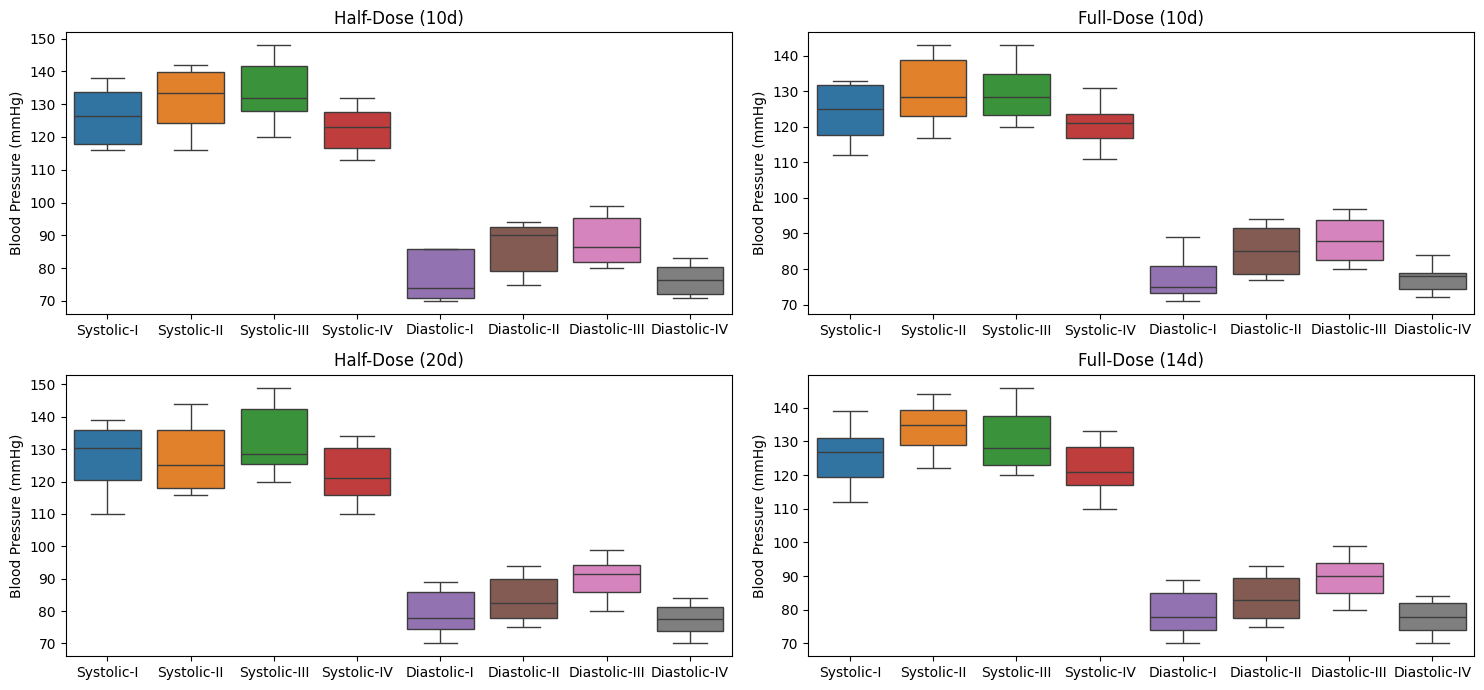

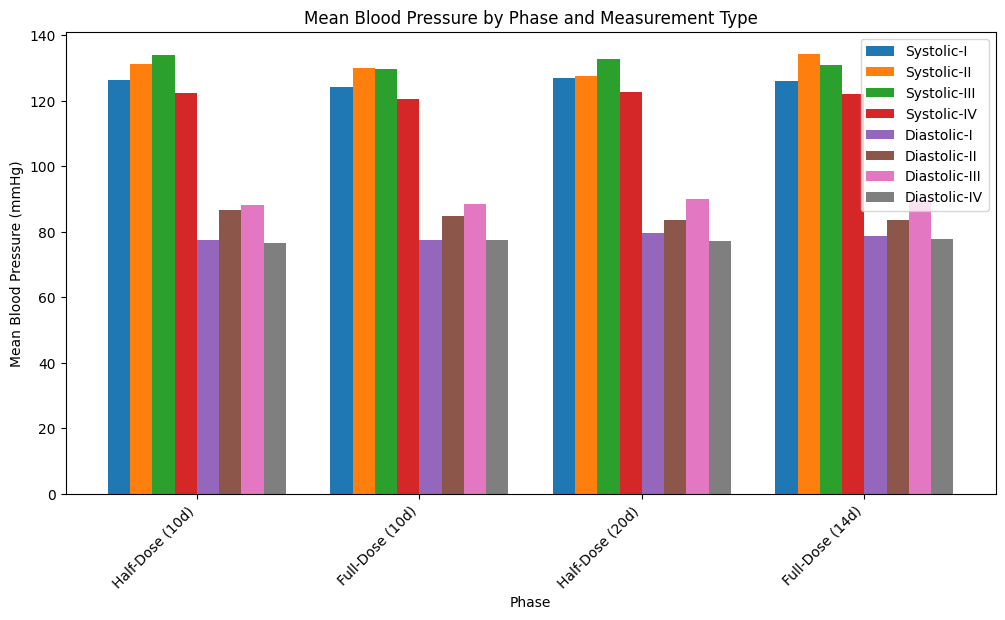

In [38]:
# Simulated data
dates = pd.date_range(start="2024-01-01", periods=62, freq="D")

# Random blood pressure data for 4 participants
np.random.seed(42)
BP_sys_Z = np.random.randint(110, 140, size=len(dates))
BP_sys_R = np.random.randint(115, 145, size=len(dates))
BP_sys_O = np.random.randint(120, 150, size=len(dates))
BP_sys_J = np.random.randint(110, 135, size=len(dates))

BP_dia_Z = np.random.randint(70, 90, size=len(dates))
BP_dia_R = np.random.randint(75, 95, size=len(dates))
BP_dia_O = np.random.randint(80, 100, size=len(dates))
BP_dia_J = np.random.randint(70, 85, size=len(dates))

# 1. Line Plot for Blood Pressure Changes
plt.figure(figsize=(15, 7))
plt.plot(dates, BP_sys_Z, label='Systolic I', marker='o')
plt.plot(dates, BP_sys_R, label='Systolic II', marker='o')
plt.plot(dates, BP_sys_O, label='Systolic III', marker='o')
plt.plot(dates, BP_sys_J, label='Systolic IV', marker='o')

plt.plot(dates, BP_dia_Z, label='Diastolic I', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_R, label='Diastolic II', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_O, label='Diastolic III', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_J, label='Diastolic IV', linestyle='dashed', marker='s')

# Add phase separators and labels
phases = [0, 10, 21, 41, 61]  
phase_labels = ['Half-Dose\n(10d)', 'Full-Dose\n(10d)', 'Half-Dose\n(20d)', 'Full-Dose\n(14d)']
for p in phases[1:-1]:
    plt.axvline(x=dates[p], color='gray', linestyle='--', alpha=0.5)

plt.title('Blood Pressure Changes During Different Supplement Doses', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Blood Pressure (mmHg)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Box Plot for Blood Pressure in Different Phases
phases_dict = {
    'Half-Dose (10d)': slice(0, 10),
    'Full-Dose (10d)': slice(11, 21),
    'Half-Dose (20d)': slice(22, 42),
    'Full-Dose (14d)': slice(43, None)
}

plt.figure(figsize=(15, 7))
for i, (phase, index) in enumerate(phases_dict.items(), 1):
    plt.subplot(2, 2, i)
    phase_data = pd.DataFrame({
        'Systolic-I': BP_sys_Z[index], 'Systolic-II': BP_sys_R[index],
        'Systolic-III': BP_sys_O[index], 'Systolic-IV': BP_sys_J[index],
        'Diastolic-I': BP_dia_Z[index], 'Diastolic-II': BP_dia_R[index],
        'Diastolic-III': BP_dia_O[index], 'Diastolic-IV': BP_dia_J[index]
    })
    sns.boxplot(data=phase_data)
    plt.title(phase)
    plt.ylabel('Blood Pressure (mmHg)')

plt.tight_layout()
plt.show()

# 3. Mean Blood Pressure Changes
mean_bp = {
    'Phase': list(phases_dict.keys()),
    'Systolic-I': [BP_sys_Z[index].mean() for index in phases_dict.values()],
    'Systolic-II': [BP_sys_R[index].mean() for index in phases_dict.values()],
    'Systolic-III': [BP_sys_O[index].mean() for index in phases_dict.values()],
    'Systolic-IV': [BP_sys_J[index].mean() for index in phases_dict.values()],
    'Diastolic-I': [BP_dia_Z[index].mean() for index in phases_dict.values()],
    'Diastolic-II': [BP_dia_R[index].mean() for index in phases_dict.values()],
    'Diastolic-III': [BP_dia_O[index].mean() for index in phases_dict.values()],
    'Diastolic-IV': [BP_dia_J[index].mean() for index in phases_dict.values()]
}

means_df = pd.DataFrame(mean_bp)

plt.figure(figsize=(12, 6))
bar_width = 0.1
r1 = np.arange(len(means_df['Phase']))
r_positions = [r1 + i*bar_width for i in range(8)]

for i, col in enumerate(means_df.columns[1:]):
    plt.bar(r_positions[i], means_df[col], width=bar_width, label=col)

plt.xlabel('Phase')
plt.ylabel('Mean Blood Pressure (mmHg)')
plt.title('Mean Blood Pressure by Phase and Measurement Type')
plt.xticks(r1 + (bar_width*3.5), means_df['Phase'], rotation=45, ha="right")
plt.legend()
plt.show()


---

### **Interactive Dashboards for Blood Prussure(Systolic, Diastolic)**

### **Interactive Blood prussure(Systolic, Diastolic) over time for each participant.**

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define blood pressure measurement columns
bp_systolic_columns = {
    'I': 'Blood-Pressure(systolic)(mmHg)-Z',
    'II': 'Blood-Pressure(systolic)(mmHg)-R',
    'III': 'Blood-Pressure(systolic)(mmHg)-O',
    'IV': 'Blood-Pressure(systolic)(mmHg)-J'
}

bp_diastolic_columns = {
    'I': 'Blood-Pressure(diastolic)(mmHg)-Z',
    'II': 'Blood-Pressure(diastolic)(mmHg)-R',
    'III': 'Blood-Pressure(diastolic)(mmHg)-O',
    'IV': 'Blood-Pressure(diastolic)(mmHg)-J'
}

# Function to plot Blood Pressure over time
def plot_bp_over_time(selected_user):
    systolic_col = bp_systolic_columns[selected_user]
    diastolic_col = bp_diastolic_columns[selected_user]

    # Filter and clean dataset
    user_data = df_filled[['Date', systolic_col, diastolic_col]].dropna()
    user_data.rename(columns={systolic_col: 'Systolic BP', diastolic_col: 'Diastolic BP'}, inplace=True)

    # Create a line plot
    plt.figure(figsize=(10, 5))
    plt.plot(user_data['Date'], user_data['Systolic BP'], marker='o', linestyle='-', label=f"Systolic BP - {selected_user}", color='blue')
    plt.plot(user_data['Date'], user_data['Diastolic BP'], marker='o', linestyle='-', label=f"Diastolic BP - {selected_user}", color='red')

    # Customize plot appearance
    plt.xlabel('Date')
    plt.ylabel('Blood Pressure (mmHg)')
    plt.title(f'Blood Pressure Over Time - User {selected_user}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Show the plot
    plt.show()

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=list(bp_systolic_columns.keys()),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(plot_bp_over_time, selected_user=user_dropdown)


Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

interactive(children=(Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=Description…

#### **Interactive Box plot for Average of Blood prussure(Systolic, Diastolic) for All participantsin all Phases.**

In [40]:
# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define blood pressure measurement columns
bp_systolic_columns = {
    'I': 'Blood-Pressure(systolic)(mmHg)-Z',
    'II': 'Blood-Pressure(systolic)(mmHg)-R',
    'III': 'Blood-Pressure(systolic)(mmHg)-O',
    'IV': 'Blood-Pressure(systolic)(mmHg)-J'
}

bp_diastolic_columns = {
    'I': 'Blood-Pressure(diastolic)(mmHg)-Z',
    'II': 'Blood-Pressure(diastolic)(mmHg)-R',
    'III': 'Blood-Pressure(diastolic)(mmHg)-O',
    'IV': 'Blood-Pressure(diastolic)(mmHg)-J'
}

# Convert blood pressure values to numeric
for col in list(bp_systolic_columns.values()) + list(bp_diastolic_columns.values()):
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Ensure 'Date' column exists and is in datetime format
if 'Date' in df_filled.columns:
    df_filled['Date'] = pd.to_datetime(df_filled['Date'])

# Determine the number of rows per phase
num_rows = len(df_filled)
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
df_filled['Phase'] = np.tile(phase_labels, num_rows // len(phase_labels) + 1)[:num_rows]

# Convert DataFrame into long format for plotting
df_systolic_long = pd.melt(df_filled, id_vars=['Date', 'Phase'], value_vars=bp_systolic_columns.values(), var_name='Participant', value_name='Systolic BP')
df_diastolic_long = pd.melt(df_filled, id_vars=['Date', 'Phase'], value_vars=bp_diastolic_columns.values(), var_name='Participant', value_name='Diastolic BP')

# Rename participants
df_systolic_long['Participant'] = df_systolic_long['Participant'].map({v: k for k, v in bp_systolic_columns.items()})
df_diastolic_long['Participant'] = df_diastolic_long['Participant'].map({v: k for k, v in bp_diastolic_columns.items()})

# List of unique participants
participants = ['All Participants'] + list(bp_systolic_columns.keys())

# Dropdown Widget
dropdown = widgets.Dropdown(
    options=participants,
    description='Select Participant:',
    style={'description_width': 'initial'}
)

# Function to plot boxplot
def update_boxplot(selected_participant):
    plt.figure(figsize=(12, 5))
    
    if selected_participant == 'All Participants':
        sns.boxplot(data=df_systolic_long, x='Phase', y='Systolic BP', hue='Participant', palette='Blues', linewidth=1)
        plt.title("Systolic Blood Pressure Distribution Across Phases (All Participants)")
    else:
        subset_systolic = df_systolic_long[df_systolic_long['Participant'] == selected_participant]
        subset_diastolic = df_diastolic_long[df_diastolic_long['Participant'] == selected_participant]

        if subset_systolic.empty or subset_diastolic.empty:
            print(f"No data available for {selected_participant}")
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        sns.boxplot(data=subset_systolic, x='Phase', y='Systolic BP', palette='Blues', linewidth=1, ax=axes[0])
        axes[0].set_title(f"Systolic Blood Pressure - {selected_participant}")
        axes[0].set_xlabel("Phase")
        axes[0].set_ylabel("Blood Pressure (mmHg)")

        sns.boxplot(data=subset_diastolic, x='Phase', y='Diastolic BP', palette='Reds', linewidth=1, ax=axes[1])
        axes[1].set_title(f"Diastolic Blood Pressure - {selected_participant}")
        axes[1].set_xlabel("Phase")
        axes[1].set_ylabel("Blood Pressure (mmHg)")

        plt.tight_layout()

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Display dropdown and connect it to function
interactive_plot = widgets.interactive(update_boxplot, selected_participant=dropdown)
display(dropdown, interactive_plot)


Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

interactive(children=(Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III…

### **Interactive Bar chart for Blood prussure(Systolic, Diastolic) over phases**

In [41]:
# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define Blood Pressure measurement columns (Systolic & Diastolic)
bp_systolic_columns = {
    'I': 'Blood-Pressure(systolic)(mmHg)-Z',
    'II': 'Blood-Pressure(systolic)(mmHg)-R',
    'III': 'Blood-Pressure(systolic)(mmHg)-O',
    'IV': 'Blood-Pressure(systolic)(mmHg)-J'
}

bp_diastolic_columns = {
    'I': 'Blood-Pressure(diastolic)(mmHg)-Z',
    'II': 'Blood-Pressure(diastolic)(mmHg)-R',
    'III': 'Blood-Pressure(diastolic)(mmHg)-O',
    'IV': 'Blood-Pressure(diastolic)(mmHg)-J'
}

# Convert Blood Pressure values to numeric
for col in list(bp_systolic_columns.values()) + list(bp_diastolic_columns.values()):
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Function to generate bar charts for the selected user
def analyze_user(selected_user):
    systolic_col = bp_systolic_columns[selected_user]
    diastolic_col = bp_diastolic_columns[selected_user]

    # Filter and clean dataset
    user_data = df_filled[['Intake-Dose', systolic_col, diastolic_col]].dropna()
    user_data = user_data[user_data['Intake-Dose'] != 'Break']
    user_data.rename(columns={systolic_col: 'Systolic', diastolic_col: 'Diastolic', 'Intake-Dose': 'Phase'}, inplace=True)
    user_data['Phase'] = user_data['Phase'].str.strip()

    # Calculate mean values per phase
    mean_systolic = user_data.groupby('Phase')['Systolic'].mean()
    mean_diastolic = user_data.groupby('Phase')['Diastolic'].mean()

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    
    # Plot systolic
    bars1 = plt.bar(mean_systolic.index, mean_systolic.values, width=0.4, color='blue', label='Systolic BP', align='center')
    # Plot diastolic
    bars2 = plt.bar(mean_diastolic.index, mean_diastolic.values, width=0.4, color='red', label='Diastolic BP', align='edge')

    # Add numerical values on top of bars
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Phase')
    plt.ylabel('Mean Blood Pressure (mmHg)')
    plt.title(f'Blood Pressure - User {selected_user}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=list(bp_systolic_columns.keys()),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(analyze_user, selected_user=user_dropdown)


Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

interactive(children=(Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=Description…

###  **Interactive Scatter polt and Linear regression for Blood prussure(Systolic, Diastolic)**

In [42]:
# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define Blood Pressure measurement columns (Systolic & Diastolic)
bp_systolic_columns = {
    'I': 'Blood-Pressure(systolic)(mmHg)-Z',
    'II': 'Blood-Pressure(systolic)(mmHg)-R',
    'III': 'Blood-Pressure(systolic)(mmHg)-O',
    'IV': 'Blood-Pressure(systolic)(mmHg)-J'
}

bp_diastolic_columns = {
    'I': 'Blood-Pressure(diastolic)(mmHg)-Z',
    'II': 'Blood-Pressure(diastolic)(mmHg)-R',
    'III': 'Blood-Pressure(diastolic)(mmHg)-O',
    'IV': 'Blood-Pressure(diastolic)(mmHg)-J'
}

roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

fig = go.Figure()

# Creating dropdown options
dropdown_options = []
for i, (label, sys_col, dia_col) in enumerate(zip(roman_labels, bp_systolic_columns.values(), bp_diastolic_columns.values())):
    sys_data = pd.to_numeric(df_filled[sys_col], errors='coerce').dropna()
    dia_data = pd.to_numeric(df_filled[dia_col], errors='coerce').dropna()
    aligned_index = df_filled.index[df_filled[sys_col].notna()]  # Keep only valid indices

    # Linear regression for Systolic & Diastolic
    if len(sys_data) > 1:
        sys_slope, sys_intercept, _, _, _ = stats.linregress(aligned_index, sys_data)
    else:
        sys_slope, sys_intercept = 0, sys_data.mean() if not sys_data.empty else 0

    if len(dia_data) > 1:
        dia_slope, dia_intercept, _, _, _ = stats.linregress(aligned_index, dia_data)
    else:
        dia_slope, dia_intercept = 0, dia_data.mean() if not dia_data.empty else 0

    # Scatter plot for Systolic Blood Pressure
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=sys_data, 
        mode='markers', 
        name=f'Systolic BP {label}',
        marker=dict(size=6, opacity=0.7, color='blue'),
        visible=(i == 0)
    ))

    # Regression line for Systolic Blood Pressure
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=sys_slope * df_filled.index + sys_intercept,
        mode='lines',
        name=f'Systolic BP Regression {label}',
        line=dict(dash='dash', color='blue'),
        visible=(i == 0)
    ))

    # Scatter plot for Diastolic Blood Pressure
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=dia_data, 
        mode='markers', 
        name=f'Diastolic BP {label}',
        marker=dict(size=6, opacity=0.7, color='red'),
        visible=(i == 0)
    ))

    # Regression line for Diastolic Blood Pressure
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=dia_slope * df_filled.index + dia_intercept,
        mode='lines',
        name=f'Diastolic BP Regression {label}',
        line=dict(dash='dash', color='red'),
        visible=(i == 0)
    ))

    dropdown_options.append(
        dict(label=label,
             method="update",
             args=[{"visible": [j // 4 == i for j in range(4 * len(roman_labels))]},
                   {"title": f"Blood Pressure Scatter Plot & Regression - {label}"}])
    )

fig.update_layout(
    title="Blood Pressure Scatter Plot",
    xaxis_title="Index (Time)",
    yaxis_title="Blood Pressure (mmHg)",
    updatemenus=[dict(buttons=dropdown_options, direction="down", showactive=True)],
    template="plotly_white"
)

fig.show()


### **Interactive Analyze_user for Blood Prussure (Systolic, Diastolic)**

In [43]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ipywidgets as widgets
from IPython.display import display

# Ensure column names are clean
df_filled.columns = df_filled.columns.str.strip()

# Define Blood Pressure measurement columns (Systolic & Diastolic)
bp_systolic_columns = {
    'I': 'Blood-Pressure(systolic)(mmHg)-Z',
    'II': 'Blood-Pressure(systolic)(mmHg)-R',
    'III': 'Blood-Pressure(systolic)(mmHg)-O',
    'IV': 'Blood-Pressure(systolic)(mmHg)-J'
}

bp_diastolic_columns = {
    'I': 'Blood-Pressure(diastolic)(mmHg)-Z',
    'II': 'Blood-Pressure(diastolic)(mmHg)-R',
    'III': 'Blood-Pressure(diastolic)(mmHg)-O',
    'IV': 'Blood-Pressure(diastolic)(mmHg)-J'
}

# Convert BP values to numeric
for col in list(bp_systolic_columns.values()) + list(bp_diastolic_columns.values()):
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Create a dropdown for selecting a participant
dropdown = widgets.Dropdown(
    options=['All Participants'] + list(bp_systolic_columns.keys()),
    description='Select Participant:',
    style={'description_width': 'initial'}
)

# Function to compute statistics
def update_statistics(selected_participant):
    if selected_participant == 'All Participants':
        selected_systolic = list(bp_systolic_columns.values())
        selected_diastolic = list(bp_diastolic_columns.values())
    else:
        selected_systolic = [bp_systolic_columns[selected_participant]]
        selected_diastolic = [bp_diastolic_columns[selected_participant]]

    if not selected_systolic or not selected_diastolic:
        print("No data available for the selected participant.")
        return

    # Compute Summary Statistics
    systolic_stats = df_filled[selected_systolic].describe().T
    diastolic_stats = df_filled[selected_diastolic].describe().T

    # Normality Test (Shapiro-Wilk)
    systolic_normality = {col: stats.shapiro(df_filled[col].dropna()).pvalue for col in selected_systolic}
    diastolic_normality = {col: stats.shapiro(df_filled[col].dropna()).pvalue for col in selected_diastolic}

    systolic_normality_df = pd.DataFrame({
        "Participant": selected_systolic,
        "Shapiro-W p-value": [systolic_normality[col] for col in selected_systolic]
    })
    
    diastolic_normality_df = pd.DataFrame({
        "Participant": selected_diastolic,
        "Shapiro-W p-value": [diastolic_normality[col] for col in selected_diastolic]
    })

    # Homogeneity Test (Levene's Test)
    if len(selected_systolic) > 1:
        levene_test_systolic = stats.levene(*(df_filled[col].dropna() for col in selected_systolic))
        homogeneity_p_value_systolic = levene_test_systolic.pvalue
    else:
        homogeneity_p_value_systolic = "N/A (Only one participant selected)"

    if len(selected_diastolic) > 1:
        levene_test_diastolic = stats.levene(*(df_filled[col].dropna() for col in selected_diastolic))
        homogeneity_p_value_diastolic = levene_test_diastolic.pvalue
    else:
        homogeneity_p_value_diastolic = "N/A (Only one participant selected)"

    # ANOVA Test
    if len(selected_systolic) > 1:
        anova_test_systolic = stats.f_oneway(*(df_filled[col].dropna() for col in selected_systolic))
        anova_p_value_systolic = anova_test_systolic.pvalue
    else:
        anova_p_value_systolic = "N/A (Only one participant selected)"

    if len(selected_diastolic) > 1:
        anova_test_diastolic = stats.f_oneway(*(df_filled[col].dropna() for col in selected_diastolic))
        anova_p_value_diastolic = anova_test_diastolic.pvalue
    else:
        anova_p_value_diastolic = "N/A (Only one participant selected)"

    # Display Results
    print("\n📌 **Summary Statistics for Systolic Blood Pressure**")
    display(systolic_stats)
    print("\n📌 **Summary Statistics for Diastolic Blood Pressure**")
    display(diastolic_stats)

    print("\n📊 **Normality Test (Shapiro-Wilk p-values) for Systolic BP**")
    display(systolic_normality_df)
    print("\n📊 **Normality Test (Shapiro-Wilk p-values) for Diastolic BP**")
    display(diastolic_normality_df)

    print(f"\n📈 **Levene's Test for Homogeneity of Variance (Systolic BP) p-value:** {homogeneity_p_value_systolic}")
    print(f"📈 **Levene's Test for Homogeneity of Variance (Diastolic BP) p-value:** {homogeneity_p_value_diastolic}")
    
    print(f"\n📊 **ANOVA Test for Mean Comparison (Systolic BP) p-value:** {anova_p_value_systolic}")
    print(f"📊 **ANOVA Test for Mean Comparison (Diastolic BP) p-value:** {anova_p_value_diastolic}")

# Connect dropdown to function
interactive_output = widgets.interactive(update_statistics, selected_participant=dropdown)

# Display Dropdown and Results
display(dropdown, interactive_output)


Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

interactive(children=(Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III…

---

## **Section 5**
### **Glucose**


### **QQ plot for Glucose**

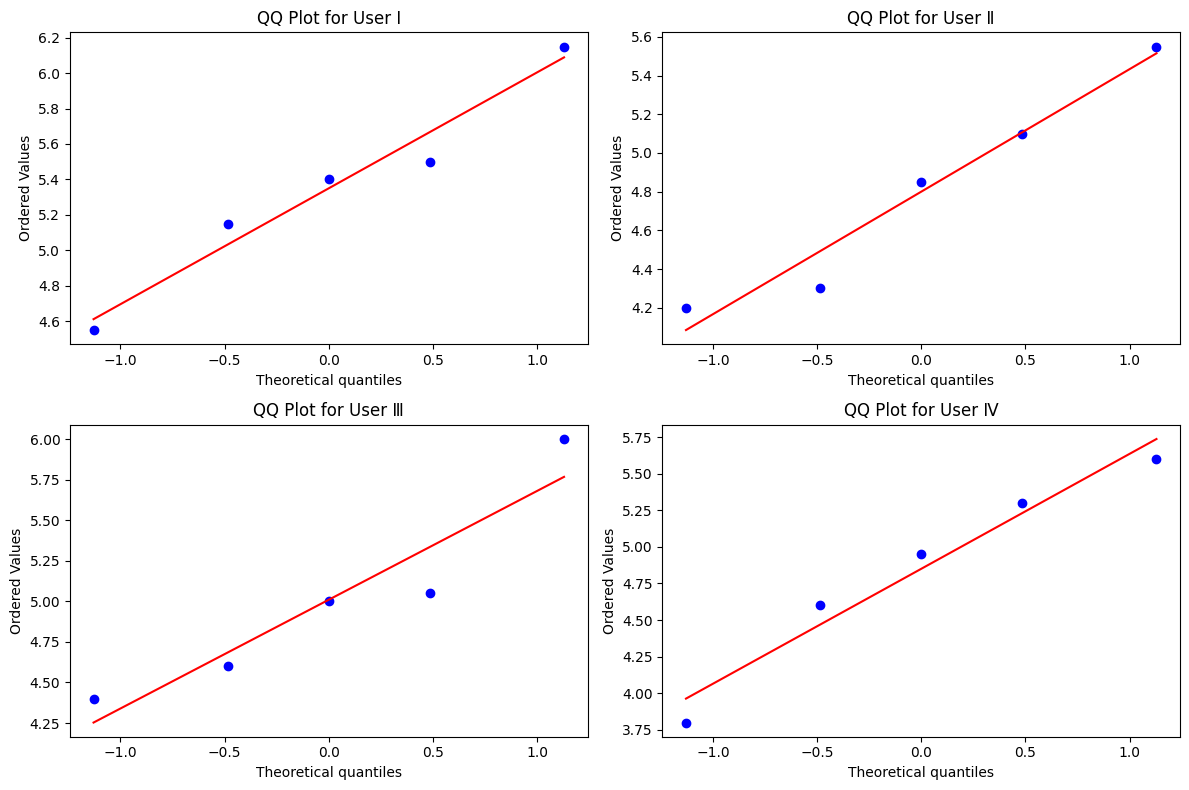

In [44]:

# Define column names for each metric
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

plt.figure(figsize=(12, 8))


for i, (col, roman) in enumerate(zip(Glucose_columns, roman_labels), 1):
    plt.subplot(2, 2, i) 
    stats.probplot(df_Glucose[col].dropna(), dist="norm", plot=plt) 
    plt.title(f'QQ Plot for {roman}') 

plt.tight_layout()
plt.show()




### **Interactive QQ plot for Glucose**

In [45]:
# Define the column names for Glucose(mmol/l)
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

def create_qq_plot(columns, title):
    fig = go.Figure()

    for col, roman in zip(columns, roman_labels):
        data = pd.to_numeric(df_Glucose[col], errors='coerce').dropna()  # Ensure numeric values only
        
        if data.empty:
            print(f"Warning: No valid numeric data for {roman}, skipping.")
            continue  # Skip if no valid data
        
        # Perform Q-Q plot calculation
        osm, osr = stats.probplot(data, dist="norm")[0]  # Extract only the quantiles

        # Add scatter plot for each user
        fig.add_trace(go.Scatter(
            x=osm, 
            y=osr, 
            mode='markers', 
            name=f'QQ Plot for {roman}',
            marker=dict(size=6, opacity=0.7)
        ))

    # Add reference (y=x) line
    if fig.data:
        min_val = min(fig.data[0].x)
        max_val = max(fig.data[0].x)
    else:
        min_val, max_val = 0, 1

    fig.add_trace(go.Scatter(
        x=[min_val, max_val], 
        y=[min_val, max_val], 
        mode='lines', 
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Theoretical Quantiles",
        yaxis_title="Ordered Values",
        template="plotly_white"
    )

    fig.show()

# Generate QQ plots for metric

create_qq_plot(Glucose_columns, "Interactive QQ Plot for Glucose(mmol/l)")


In [46]:
df_Glucose.head()

,Date,Test Type,Glucose(mmol/l)-Z,Glucose(mmol/l)-R,Glucose(mmol/l)-O,Glucose(mmol/l)-J
0,11/28/2024,BaseLine-Test,4.55,4.85,4.40,3.80
1,12/9/2024,The First_Test (HalfDose),6.15,4.30,5.00,5.30
2,12/19/2024,The Second_Test fullDose),5.40,4.20,4.60,4.60
3,1/9/2025,The Second_Test (HalfDose),5.50,5.55,5.05,5.60
4,1/30/2025,The Second_Test (FullDose),5.15,5.10,6.00,4.95


In [47]:
df_Glucose.columns

Index(['Date', 'Test Type', 'Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R',
       'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J'],
      dtype='object')

### **Bar Chart for Average of Glucose**

In [48]:
# Define columns and labels
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']
# Convert to numeric to avoid errors
for col in Glucose_columns:
    df_Glucose[col] = pd.to_numeric(df_Glucose[col], errors='coerce')

# Calculate means
Glucose_means = [df_Glucose[col].mean() for col in Glucose_columns]

# Create DataFrames for plotting
df_Glucose_avg = pd.DataFrame({'Person': roman_labels, 'Glucose_level(mmol/l)': Glucose_means})

# Interactive bar plot for Heart-rate
fig2 = px.bar(df_Glucose_avg, x='Person', y='Glucose_level(mmol/l)', text='Glucose_level(mmol/l)',
              title='Average Glucose(mmol/l) per Person', template="plotly_dark",
              color='Glucose_level(mmol/l)', color_continuous_scale='purples')

fig2.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig2.show()


### **Distribution for Glucose**

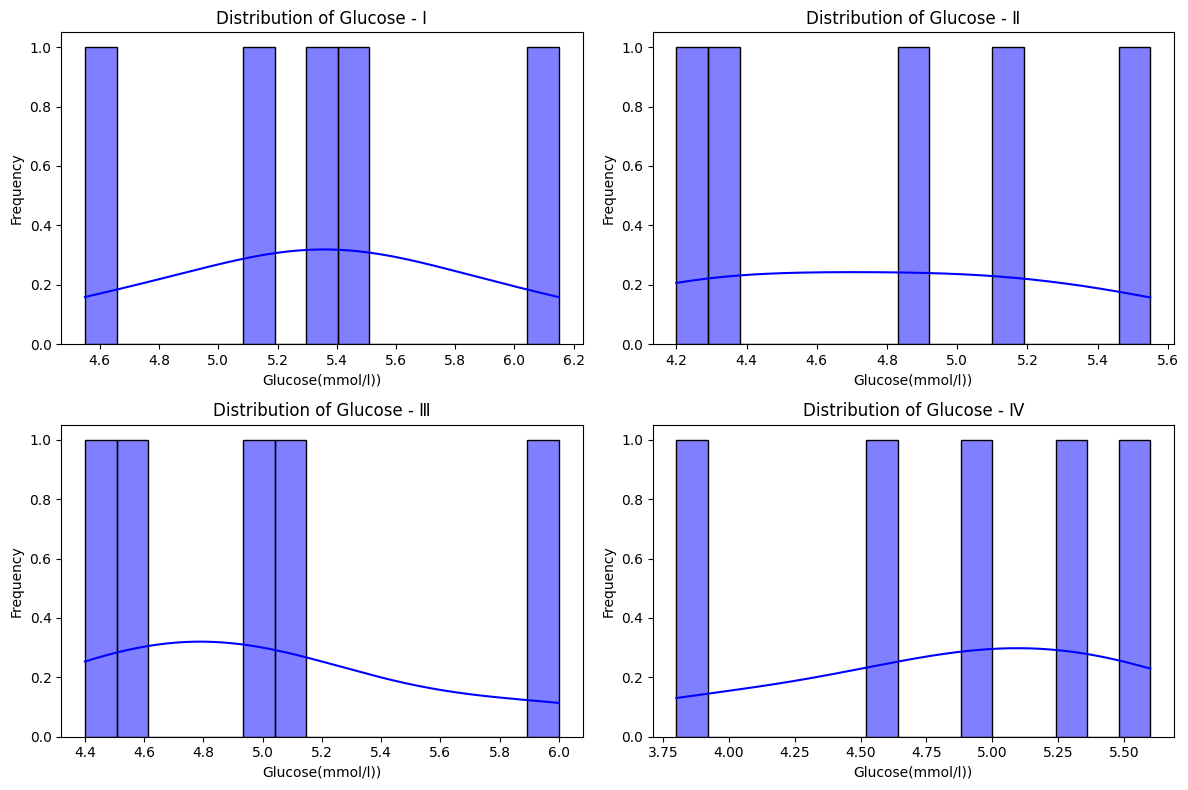

In [49]:
# Define columns and labels
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']
# Convert to numeric to avoid errors
for col in Glucose_columns:
    df_Glucose[col] = pd.to_numeric(df_Glucose[col], errors='coerce')


# 🔵 
plt.figure(figsize=(12, 8))
for i, (col, roman) in enumerate(zip(Glucose_columns, roman_labels), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_Glucose[col], kde=True, bins=15, color='blue')
    plt.title(f'Distribution of Glucose - {roman}')
    plt.xlabel('Glucose(mmol/l))')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



### **Box Plot for Glucose**

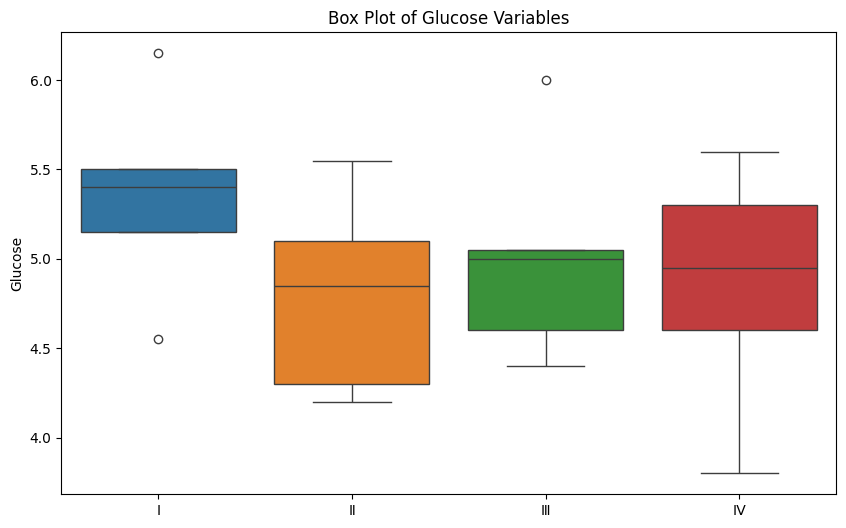

In [50]:
# Set figure size
plt.figure(figsize=(10, 6))
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
# Create a box plot for each weight column
sns.boxplot(data=df_Glucose[Glucose_columns])

# Change x-axis labels to Greek numerals
plt.xticks(ticks=range(4), labels=roman_labels)

# Add title and labels
plt.title("Box Plot of Glucose Variables")
plt.ylabel("Glucose")

# Show the plot
plt.show()

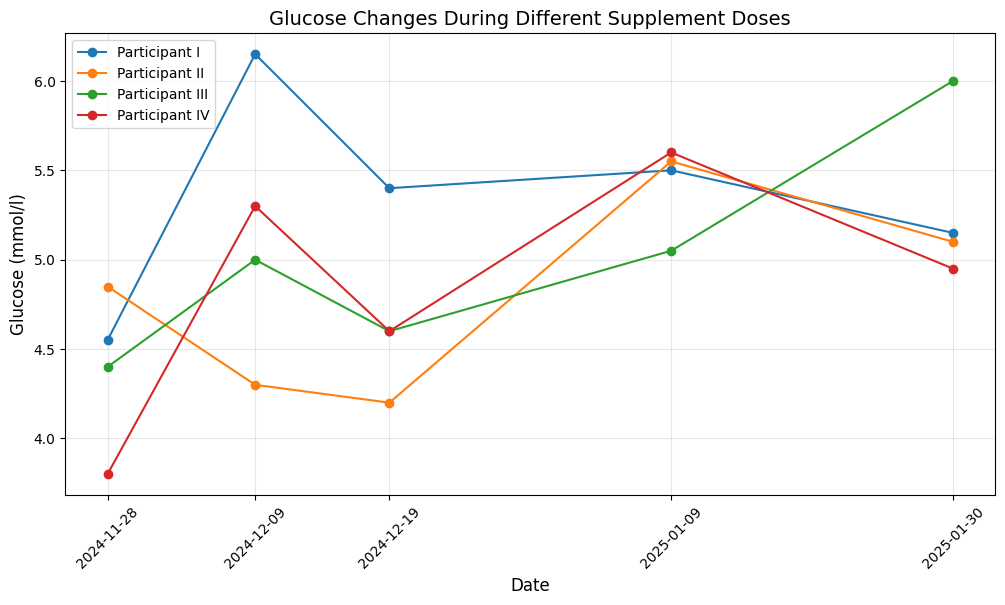

In [51]:
# Convert Date column to datetime format
df_Glucose['Date'] = pd.to_datetime(df_Glucose['Date'], errors='coerce')

# Select first 5 unique dates
unique_dates = df_Glucose['Date'].dropna().unique()[:5]  
df_Glucose_filtered = df_Glucose[df_Glucose['Date'].isin(unique_dates)].dropna()  # Filter DataFrame & drop NaNs

# Extract only 5-time points
date_column = df_Glucose_filtered['Date']

Glucose_Z = pd.to_numeric(df_Glucose_filtered['Glucose(mmol/l)-Z'], errors='coerce')
Glucose_R = pd.to_numeric(df_Glucose_filtered['Glucose(mmol/l)-R'], errors='coerce')
Glucose_O = pd.to_numeric(df_Glucose_filtered['Glucose(mmol/l)-O'], errors='coerce')
Glucose_J = pd.to_numeric(df_Glucose_filtered['Glucose(mmol/l)-J'], errors='coerce')

#  **Plot Line Chart for Only 5 Dates**
plt.figure(figsize=(12, 6))
plt.plot(date_column, Glucose_Z, label='Participant I', marker='o')
plt.plot(date_column, Glucose_R, label='Participant II', marker='o')
plt.plot(date_column, Glucose_O, label='Participant III', marker='o')
plt.plot(date_column, Glucose_J, label='Participant IV', marker='o')

# Customize plot
plt.title('Glucose Changes During Different Supplement Doses', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Glucose (mmol/l)', fontsize=12)
plt.xticks(date_column, date_column.dt.strftime('%Y-%m-%d'), rotation=45)  # ✅ Format x-axis properly
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


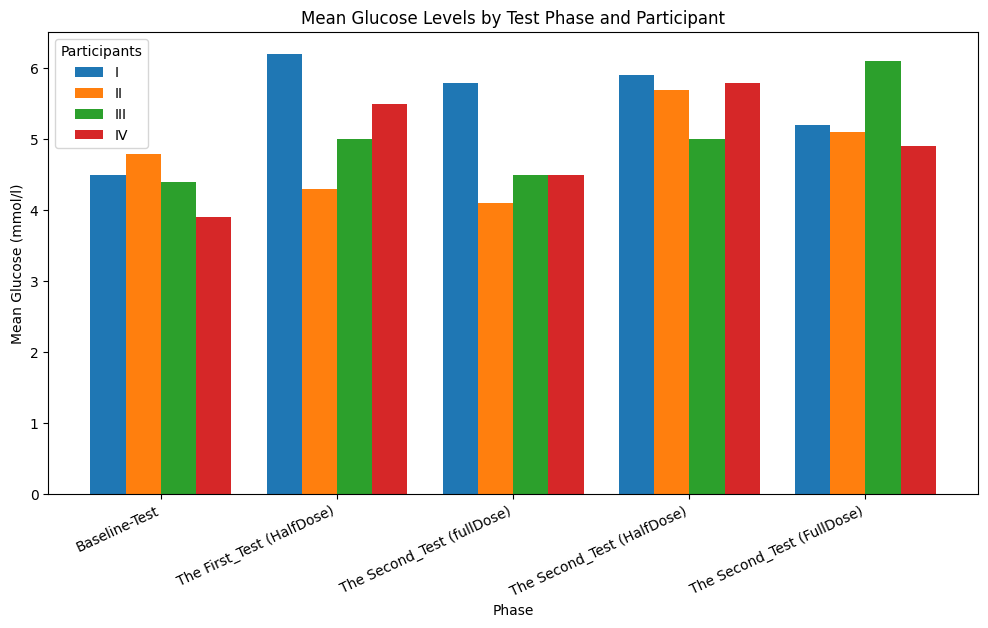

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Mean glucose levels for 4 participants in different test phases
phases = ["Baseline-Test", "The First_Test (HalfDose)", "The Second_Test (fullDose)", 
          "The Second_Test (HalfDose)", "The Second_Test (FullDose)"]

glucose_levels = {
    "I": [4.5, 6.2, 5.8, 5.9, 5.2],
    "II": [4.8, 4.3, 4.1, 5.7, 5.1],
    "III": [4.4, 5.0, 4.5, 5.0, 6.1],
    "IV": [3.9, 5.5, 4.5, 5.8, 4.9]
}

x = np.arange(len(phases))  # Positions for X-axis labels
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bar chart for each participant
for i, (participant, values) in enumerate(glucose_levels.items()):
    ax.bar(x + i * width, values, width, label=participant)

# Set labels and title
ax.set_xlabel("Phase")
ax.set_ylabel("Mean Glucose (mmol/l)")
ax.set_title("Mean Glucose Levels by Test Phase and Participant")

# Set X-axis tick positions and labels
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(phases, rotation=25, ha="right")

# Add legend to differentiate participants
ax.legend(title="Participants")

# Display the plot
plt.show()


----

### **Interactive Dashboard for Glucose parameter**
### **Interactive Scatter Plot for Glucose change**

In [53]:
# Define column names for Glucose
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['UserⅠ', 'UserⅡ', 'UserⅢ', 'UserⅣ']

# Extract unique time points (only 5)
date_column = df_Glucose['Date'][:5]  

fig = go.Figure()
summary_stats = []
dropdown_options = []

for i, (Glucose_col, roman) in enumerate(zip(Glucose_columns, roman_labels)):
    # Extract relevant Glucose data
    Glucose_data = pd.to_numeric(df_Glucose[Glucose_col], errors='coerce').dropna()
    aligned_dates = df_Glucose.loc[df_Glucose[Glucose_col].notna(), 'Date'].unique()[:5]  # Keep only valid dates

    # Linear regression (only if enough data)
    if len(Glucose_data) > 1:
        aligned_index = range(len(aligned_dates))  # Reindex for regression
        Glucose_slope, Glucose_intercept, _, _, _ = stats.linregress(aligned_index, Glucose_data[:5])
    else:
        Glucose_slope, Glucose_intercept = 0, Glucose_data.mean() if not Glucose_data.empty else 0

    # Summary Statistics
    summary_stats.append(
        pd.DataFrame({
            "Metric": ["Mean", "Std Dev", "Skewness", "Kurtosis", "Normality Test p-value"],
            "Glucose (mmol/l)": [Glucose_data.mean(), Glucose_data.std(), Glucose_data.skew(), 
                                 Glucose_data.kurtosis(), 
                                 stats.normaltest(Glucose_data).pvalue if len(Glucose_data) > 2 else None]
        })
    )

    # Scatter plot for Glucose (only 5 time points)
    fig.add_trace(go.Scatter(
        x=aligned_dates, 
        y=Glucose_data[:5],  
        mode='markers', 
        name=f'Glucose {roman}',
        marker=dict(size=8, opacity=0.7, color='blue'),
        visible=(i == 0)  # Only the first user is visible by default
    ))

    # Regression line for Glucose (only 5 points)
    fig.add_trace(go.Scatter(
        x=aligned_dates, 
        y=[Glucose_slope * x + Glucose_intercept for x in range(len(aligned_dates))],
        mode='lines',
        name=f'Glucose Regression {roman}',
        line=dict(dash='dash', color='blue'),
        visible=(i == 0)
    ))

    dropdown_options.append(
        dict(label=roman,
             method="update",
             args=[{"visible": [j // 2 == i for j in range(2 * len(roman_labels))]},
                   {"title": f"Scatter Plot & Regression - {roman}"}])
    )

# Update figure layout
fig.update_layout(
    title="Scatter Plot for Glucose(mmol/l)",
    xaxis_title="Date",
    yaxis_title="Glucose (mmol/l)",
    xaxis=dict(tickvals=date_column, ticktext=date_column),  # Show only 5 dates
    updatemenus=[dict(buttons=dropdown_options, direction="down", showactive=True)],
    template="plotly_white"
)

fig.show()

# **Interactive Summary Table**
# Dropdown Widget
dropdown = widgets.Dropdown(
    options=list(zip(roman_labels, range(len(roman_labels)))),
    description='User:',
    style={'description_width': 'initial'}
)

# Output Widget
out = Output()

# Function to update summary table
def update_summary(change):
    with out:
        out.clear_output(wait=True)
        display(summary_stats[change.new])

# Connect dropdown to function
dropdown.observe(update_summary, names='value')

# Show initial table
with out:
    display(summary_stats[0])

# Display Dropdown + Table
display(VBox([dropdown, out]))


C:\Users\ztahe\AppData\Local\Temp\ipykernel_38720\553278875.py:30: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



In [54]:
# Ensure Date column is in datetime format
df_Glucose['Date'] = pd.to_datetime(df_Glucose['Date'], errors='coerce')

# Select first 5 unique dates
unique_dates = df_Glucose['Date'].dropna().unique()[:5]  
df_Glucose_filtered = df_Glucose[df_Glucose['Date'].isin(unique_dates)].dropna()  # Filter DataFrame & drop NaNs

# Extract only 5-time points
date_column = df_Glucose_filtered['Date']

# Define Glucose measurement columns
glucose_columns = {
    'I': 'Glucose(mmol/l)-Z',
    'II': 'Glucose(mmol/l)-R',
    'III': 'Glucose(mmol/l)-O',
    'IV': 'Glucose(mmol/l)-J'
}

# Convert glucose values to numeric
for col in glucose_columns.values():
    df_Glucose_filtered[col] = pd.to_numeric(df_Glucose_filtered[col], errors='coerce')

# Create dropdown widget for selecting a participant
user_dropdown = widgets.Dropdown(
    options=list(glucose_columns.keys()),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Function to plot glucose level over time for selected user
def plot_glucose_over_time(selected_user):
    glucose_col = glucose_columns[selected_user]

    # Extract user-specific glucose data
    user_data = df_Glucose_filtered[['Date', glucose_col]].dropna()
    user_data.rename(columns={glucose_col: 'Glucose'}, inplace=True)

    # Create a line plot
    plt.figure(figsize=(10, 5))
    plt.plot(user_data['Date'], user_data['Glucose'], marker='o', linestyle='-', color='blue', label=f'Glucose - {selected_user}')

    # Customize plot appearance
    plt.xlabel('Date')
    plt.ylabel('Glucose (mmol/l)')
    plt.title(f'Glucose Level Over Time - User {selected_user}')
    plt.xticks(user_data['Date'], user_data['Date'].dt.strftime('%Y-%m-%d'), rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Show the plot
    plt.show()

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(plot_glucose_over_time, selected_user=user_dropdown)


Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

interactive(children=(Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=Description…

In [55]:
# Ensure column names are clean
df_Glucose.columns = df_Glucose.columns.str.strip()

# Define glucose measurement columns
glucose_columns = {
    'I': 'Glucose(mmol/l)-Z',
    'II': 'Glucose(mmol/l)-R',
    'III': 'Glucose(mmol/l)-O',
    'IV': 'Glucose(mmol/l)-J'
}

# Create dropdown widget for selecting a participant
user_dropdown = widgets.Dropdown(
    options=list(glucose_columns.keys()),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Function to plot a bar chart for the selected user
def plot_glucose_bar_chart(selected_user):
    glucose_col = glucose_columns[selected_user]

    # Filter and clean dataset
    user_data = df_Glucose[['Test Type', glucose_col]].dropna()
    user_data.rename(columns={glucose_col: 'Glucose', 'Test Type': 'Phase'}, inplace=True)
    user_data['Phase'] = user_data['Phase'].str.strip()

    # Calculate mean glucose values per phase
    mean_glucose = user_data.groupby('Phase')['Glucose'].mean()

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(mean_glucose.index, mean_glucose.values, color=['blue', 'green', 'orange', 'red'])

    # Add numerical values on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Phase')
    plt.ylabel('Mean Glucose (mmol/L)')
    plt.title(f'Glucose Levels - User {selected_user}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(plot_glucose_bar_chart, selected_user=user_dropdown)




Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=DescriptionStyle(description_widt…

interactive(children=(Dropdown(description='Select User:', options=('I', 'II', 'III', 'IV'), style=Description…

### **Interactive Dashboard of Statistical Analysis for Glucose**

In [56]:
# Ensure column names are clean
df_Glucose.columns = df_Glucose.columns.str.strip()

# Define Glucose measurement columns
glucose_columns = {
    'I': 'Glucose(mmol/l)-Z',
    'II': 'Glucose(mmol/l)-R',
    'III': 'Glucose(mmol/l)-O',
    'IV': 'Glucose(mmol/l)-J'
}

# Convert Glucose values to numeric
for col in glucose_columns.values():
    df_Glucose[col] = pd.to_numeric(df_Glucose[col], errors='coerce')

# Create a dropdown for selecting a participant
dropdown = widgets.Dropdown(
    options=['All Participants'] + list(glucose_columns.keys()),
    description='Select Participant:',
    style={'description_width': 'initial'}
)

# Function to compute statistics
def update_statistics(selected_participant):
    if selected_participant == 'All Participants':
        selected_columns = list(glucose_columns.values())
    else:
        selected_columns = [glucose_columns[selected_participant]]

    if not selected_columns:
        print("No data available for the selected participant.")
        return

    # Compute Summary Statistics
    summary_stats = df_Glucose[selected_columns].describe().T

    # Normality Test (Shapiro-Wilk)
    normality_results = {col: stats.shapiro(df_Glucose[col].dropna()).pvalue for col in selected_columns}
    normality_df = pd.DataFrame({
        "Participant": selected_columns,
        "Shapiro-W p-value": [normality_results[col] for col in selected_columns]
    })

    # Homogeneity Test (Levene's Test)
    if len(selected_columns) > 1:
        levene_test = stats.levene(*(df_Glucose[col].dropna() for col in selected_columns))
        homogeneity_p_value = levene_test.pvalue
    else:
        homogeneity_p_value = "N/A (Only one participant selected)"

    # ANOVA Test
    if len(selected_columns) > 1:
        anova_test = stats.f_oneway(*(df_Glucose[col].dropna() for col in selected_columns))
        anova_p_value = anova_test.pvalue
    else:
        anova_p_value = "N/A (Only one participant selected)"

    # Display Results
    print("\n📌 **Summary Statistics for Glucose Levels**")
    display(summary_stats)

    print("\n📊 **Normality Test (Shapiro-Wilk p-values) for Glucose**")
    display(normality_df)

    print(f"\n📈 **Levene's Test for Homogeneity of Variance (Glucose) p-value:** {homogeneity_p_value}")
    print(f"\n📊 **ANOVA Test for Mean Comparison (Glucose) p-value:** {anova_p_value}")

# Connect dropdown to function
interactive_output = widgets.interactive(update_statistics, selected_participant=dropdown)

# Display Dropdown and Results
display(dropdown, interactive_output)


Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III', 'IV'), style=Descri…

interactive(children=(Dropdown(description='Select Participant:', options=('All Participants', 'I', 'II', 'III…